In [1]:
!pip install pandas dash
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv"
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/spacex_dash_app.py"
# Import required libraries
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import plotly.express as px

--2023-09-09 06:28:35--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2476 (2.4K) [text/csv]
Saving to: 'spacex_launch_dash.csv.3'

     0K ..                                                    100%  172M=0s

2023-09-09 06:28:37 (172 MB/s) - 'spacex_launch_dash.csv.3' saved [2476/2476]

--2023-09-09 06:28:37--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/spacex_dash_app.py
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-sto

In [2]:


# Read the airline data into pandas dataframe
spacex_df = pd.read_csv("spacex_launch_dash.csv")
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

# Create a dash application
app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # TASK 1: Add a dropdown list to enable Launch Site selection
                                # The default select value is for ALL sites
                                dcc.Dropdown(id='site-dropdown',
                                    options = [{'label': 'All Sites', 'value': 'ALL'}, 
                                        {'label': 'CCAFS LC-40', 'value':'CCAFS LC-40'},
                                        {'label': 'CCAFS SLC-40', 'value':'CCAFS SLC-40'}, 
                                        {'label': 'KSC LC-39A', 'value':'KSC LC-39A'}, 
                                        {'label': 'VAFB SLC-4E', 'value':'VAFB SLC-4E'}],
                                    value=None,
                                    style={'textAlign': 'left', 'color': '#503D36' , 'width': '100%', 'padding': '3px', 'font-size': '15px'},
                                    placeholder='Select a Launch Site here',
                                    searchable=True
                                    ),
                                html.Br(),

                                # TASK 2: Add a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                # TASK 3: Add a slider to select payload range
                                dcc.RangeSlider(id='payload-slider',
                                        min=0, max=10000, step=1000,
                                        marks={0: '0',
                                            100: '100',
                                            1000: '1000',
                                            10000: '10000'},
                                        value=[0, 10000]),

                                # TASK 4: Add a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id='success-payload-scatter-chart')),
                                ])

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
# Function decorator to specify function input and output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))

def get_pie_chart(entered_site):
    df = spacex_df
    successful_df = df[df['class'] == 1]
    
    if entered_site in ['CCAFS LC-40', 'CCAFS SLC-40', 'KSC LC-39A', 'VAFB SLC-4E']:    
        # return the outcomes piechart for a selected site
        df = spacex_df[spacex_df['Launch Site'] == entered_site]
        filtered_df = df.groupby(['Launch Site','class']).size().reset_index(name='class count')
        
        fig = px.pie(filtered_df, 
            values='class count', 
            names='class', 
            title=f"Proportions of Successful and Failed Launches for Site {entered_site}" )
        return fig 

    else:
        fig = px.pie(successful_df, 
            values='class', 
            names='Launch Site', 
            title='Share of Each Site of All Successful Landings')
        return fig
        
# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(Output(component_id='success-payload-scatter-chart', component_property='figure'),
              [Input(component_id='site-dropdown', component_property='value'),
               Input(component_id='payload-slider', component_property='value')])

def get_scatter_chart(entered_site, entered_payload):
    #df = spacex_df
    low,high = (entered_payload[0], entered_payload[1])
    #df = spacex_df[spacex_df['Payload Mass (kg)']].between(low,high)
    #df = df.groupby(['Launch Site','class']).size().reset_index(name='class count')
    df=spacex_df[(spacex_df['Payload Mass (kg)'] >= low) & (spacex_df['Payload Mass (kg)'] <= high)]
    

    if entered_site in ['CCAFS LC-40', 'CCAFS SLC-40', 'KSC LC-39A', 'VAFB SLC-4E']:
        filtered_df = df[df['Launch Site'] == entered_site]
        
        fig = px.scatter(filtered_df, 
            x='Payload Mass (kg)',
            y='class',
            color='Booster Version Category', 
            title=f'Mission Outcome Vs. Payload Mass (kg) for {entered_site} Launch Site')
        return fig

    else: 
        fig = px.scatter(df, 
            x='Payload Mass (kg)', 
            y='class',
            color='Booster Version Category',
            hover_data=['Booster Version'], 
            title='Mission Outcome Vs. Payload Mass (kg) for All Sites')
        return fig
       

# Run the app
if __name__ == '__main__':
    app.run(jupyter_mode="jupyterlab")
    app.run_server()
    


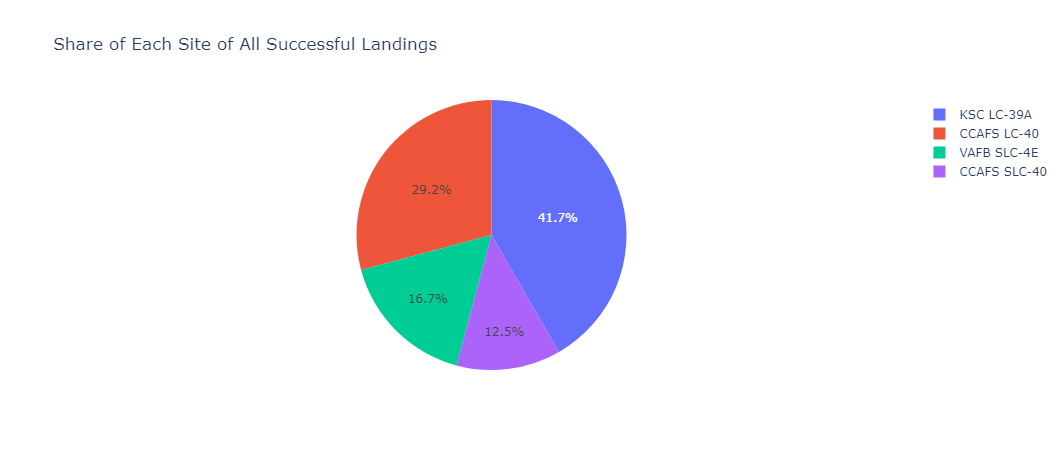

In [8]:
from IPython import display
from base64 import b64decode
pie = 'iVBORw0KGgoAAAANSUhEUgAABCcAAAHCCAYAAADchKMyAAAAAXNSR0IArs4c6QAAIABJREFUeF7s3QmUFNXZxvGnl2GAAQFBQBBQXFgiihoBNW64JKJEJdGoaEAIosYYo4HgrjHiHk3yqTEukUSNwQXRiJEoAu64BDUoiiLI6giyzD7T0/2daqyxp+mleq/l3+fkBGeq7n3v79ag9cytW75IJBIRHwQQQAABBBBAAAEEEEAAAQQQQKBEAj7CiRLJ0y0CCCCAAAIIIIAAAggggAACCEQFCCe4EBBAAAEEEEAAAQQQQAABBBBAoKQChBMl5adzBBBAAAEEEEAAAQQQQAABBBAgnOAaQAABBBBAAAEEEEAAAQQQQACBkgoQTpSUn84RQAABBBBAAAEEEEAAAQQQQIBwgmsAAQQQQAABBBBAAAEEEEAAAQRKKkA4UVJ+OkcAAQQQQAABBBBAAAEEEEAAAcIJrgEEEEAAAQQQQAABBBBAAAEEECipAOFESfnpHAEEEEAAAQQQQAABBBBAAAEECCe4BhBAAAEEEEAAAQQQQAABBBBAoKQChBMl5adzBBBAAAEEEEAAAQQQQAABBBAgnOAaQAABBBBAAAEEEEAAAQQQQACBkgoQTpSUn84RQAABBBBAAAEEEEAAAQQQQIBwgmsAAQQQQAABBBBAAAEEEEAAAQRKKkA4UVJ+OkcAAQQQQAABBBBAAAEEEEAAAcIJrgEEEEAAAQQQQAABBBBAAAEEECipAOFESfnpHAEEEEAAAQQQQAABBBBAAAEECCe4BhBAAAEEEEAAAQQQQAABBBBAoKQChBMl5adzBBBAAAEEEEAAAQQQQAABBBAgnOAaQAABBBBAAAEEEEAAAQQQQACBkgoQTpSUn84RQAABBBBAAAEEEEAAAQQQQIBwgmsAAQQQQAABBBBAAAEEEEAAAQRKKkA4UVJ+OkcAAQQQQAABBBBAAAEEEEAAAcIJrgEEEEAAAQQQQAABBBBAAAEEECipAOFESfnpHAEEEEAAAQQQQAABBBBAAAEECCe4BhBAAAEEEEAAAQQQQAABBBBAoKQChBMl5adzBBBAAAEEEEAAAQQQQAABBBAgnOAaQAABBBBAAAEEEEAAAQQQQACBkgoQTpSUn84RQAABBBBAAAEEEEAAAQQQQIBwgmsAAQQQQAABBBBAAAEEEEAAAQRKKkA4UVJ+OkcAAQQQQAABBBBAAAEEEEAAAcIJrgEEEEAAAQQQQAABBBBAAAEEECipAOFESfnpHAEEEEAAAQQQQAABBBBAAAEECCe4BhBAAAEEEEAAAQQQQAABBBBAoKQChBMl5adzBBBAAAEEEEAAAQQQQAABBBAgnOAaQAABBBBAAAEEEEAAAQQQQACBkgoQTnzD//t7ZmrR4qW6+8ZfqUunjiWdlEJ0/uSchbry5geiTQ8Z1N924/xs5VpNnnqbzh93osaMOqwQBI5q07ge7//HnGjNxx81QtdOmaB2bdvkPIb463zTliqdN+12DRs6UBdPPjXn9r3WgOn3wUfLo0O/buqEjK5fJ/+9Y9S+vvLrvF2bXrt2GC8CCCCAAAIIIIBAawHXhxOxN+WxQ3/wjmk6cOjAli85+SYh3UVtGNw1Y7buufkS7d6vV8rD42+24g/euUdXS+2kqyn++/kKJ+rqG3X1LQ/o2RffaNVFfCBjjrNvr+4tN1f5qiHTsccfn+21aNa/7suNSW+Scw0nrPrmauCE8/MR7Fid63z0lW/T+HDCvP5GjRxO0JVvbNpDAAEEEEAAAQQ8IODacMK8iXr3f8u2u5k2fysd+1tOqzcJTrsmTIee3Xe0dMNQqpugfAQDZhv7771nq9/mmmPa8PWWlmvBruGEWdepo4/I6DfwxnVphlDduuygvr17JPyNdi7hRCa+Tvs5yabetxYv1aU33JtTWGf1751S/VymciGcyOaq4RwEEEAAAQQQQACBZAKuDSeMG4fxF92o+BUSJoRxo/Xp56v1/SOGRb9k9SbBaZeSl8KJdHP4/PxF2mO3XZKuHslHQJLr9ZFtOBE7z7v26Zl0pUwu4USuvrna2O18wgke67DbNUk9CCCAAAIIIICAkwVcG05k8ihDbDgx/dJJuuyGe2U+Qx7/vH+yZe2J9gUwb+Zuv+bnuv0vj0UfNYh9LCJRW5k8s57oEYzYMCbZIxqp+sjkN7RmABT/A5AsEEr0iI15bGwwYLRn7o9h/DlZe7H9mpbG16zszxA/zthHImLbnXj6qJYVJ+m80/1FkO78ZDVYGX9sGLdjlx2S7t+RbTiRqa/5M5VoTwLjOpj5zPzt9j1JdD3FX6upriHTP/6YRD+bifqKd051TKI6zEeHXnr1v0nHF7/SIl3gY47J6s9loroSPYpl/v14x28v0N9mPt/yGFSy/Wjir02jzfgVOonCvUL0Y5hYmb90P498HwEEEEAAAQQQQMBeAq4NJ8z/eLW6maD5qEfsf5wnuiEwbtJuuftRjR1zdMtv4JPduJltJro5SPR8ttUbEOMSSnQjYI459oaukCsnjP5efvP9Vo+LJFqxYtbwxdrKVjekxhhefPkdnXPm6JbxxO+XkEnIlOhxnWQ/bomsU62cSGSbyUoLq/OV7cqJ2JvctuXl0X03EgU12YYTZthgbNJpNUBLtmFionDCOHbOvDdbPSJhWPz10ed03riTomMxxpTqGkp2ncWPOdE1Gn+dWT0m0WMdqcKXYoQThlXsprKJfobMECNRWBp/3aT6eyX22GThhBE05rMfK3Njr3/NUg0CCCCAAAIIIICAFQHXhhPG4K3+FtG88Ur0to5kNxrxuImWeKf6rWiqG7d0m1em+i12/I1ItuGEuXIkfpzpNsRM1J+VgCHZjX4mN+uZrGrJJJxIZWjlN9+ZzFcm4zXnJtFYkj3WlEs4kYmv+TNlZeVEukewzJ/ldD8XyR6ziL+2ks3Z/z7+XO3alkdDRyvHJOuvlOFEor/0E11TyX4m48eU7tqPnd9UKyfiN+PNpR8rc2PlX34cgwACCCCAAAIIIGAvAVeHEyZ1ouXy8TfZyf6DN9l/xFsJPpK1meoG1Kz1hksntXqbSOxlk+r8+Bu9bMMJq6+WTPboSOzjEMmCmNgxpQsnrNZjtplofmJX0WQSTqSaEyv7DmQyX9mEE4lu7pOtwsklnIidr3S+mYQTVgJAK9dQsmPifwbM2lOtqrJyjF3DiWSPB8WueEkVTsTu1ZNqdVCyDTFjXwdciH6szI29/jVLNQgggAACCCCAAAJWBDwRTsRDJHrrgNVwItGbH4z2M1k5kezmIbbOVPsMpLphiP9eIcMJ8yYhNoiI78/qXgX5Difi59ys1bxByyScSLa3htlHutUkmcxXNuGE+ThLoh/4+D0E8hVOpPPNJJxIt/rEyjWUbFVHbJ2x12micMXK/haxx9gxnEj0aFOmKydiw4lUq1ryGU5k0o8xp1bmz8q/ADkGAQQQQAABBBBAwD4CngwnzBun2Mc4rIYTVpdDJ+rDnPZsbkBjL5lMfhNfqHAi2W/mE/Vn5bfehQ4n4uvNJJywspol1Y90JvOV6bVhZZ+M2KCrUOFEIk+re04UeuVEur9uY4ONZKFgomPsFk6k+xmKfT1tpisaEq3kymc4kepnLN3fH1bmL901wPcRQAABBBBAAAEESi/g2nAi1WsjE/0m1mo4key4TFZOWPlNcKpLI5M9DAoVTiS7Ecpkzwnj2IVvLI6+zjXdjVW6xzqMtp54doF+dPzhate2zXZ88e0nuplOFgxkslFponnLZL4yDSdS7edhttW3V/eWN5hkG05k6psqnIsPI1L91tz4OT5sxFA9N++NhK9Hjb2GrOxtYtRlthl7ncRfH1aOSRVOJNofI5O/I+KvIyvXYDLHXFZOpOo3n+FEJv1YmZvS/6uVChBAAAEEEEAAAQQyFXBtOJHsuWTzRvHd/y1r9WYAq+FEohsA82tW97EwJinRoyXG14364t8GkmhSE73to5hv60h0wx37G8xEj3rEvmkhPsTIRzhhvM3BeF1r/PL8RNaJboZShQimbey4jHkx2rnhjw/r0gvHqkunjkl//qzOVybhhJWQK/6GPZdwIhNfAyLZWxWMtzcketwk/m0dsTe/Rnvxb+tI9ghR/M+2ca7hYHyMt1gk+llP52S2ERs6WN2AM9Yik78jYi8mK+FEqsDN2OA2mz0nEo3b/Joxj7H7dmS6IWbs4yOZ9GNl/jL9FyHHI4AAAggggAACCJRewLXhROwNQTxz/A2m8X2r4USido32Dh2+jzJ9TWCy5+QT1ZfoUkm0GWX8svRsV05YeVtHfP3Gjdcdv71Af5v5vHp237HVK0ZNY+NVlOYn3Y2NefN/3rTblW7lhNlmsv0X4l2S3ezFm8bORSJvo1+rr9a0Ml+ZhBOJwqj46yTdmyqs3PTGtmnV1zwnfm8Aw8r4zHxmfqvXysbe8JrnxgcY6a6hZH0aX49tK9HPXXxfVo5JtRlq/D4l2f4dYY4p2bUX/7NU39Ag4+fF/Pk1xjX90km67IZ7lc1jHanmccWq9crlbR3x4USia8C4XuL7sTI3pf9XKxUggAACCCCAAAIIZCrg6nAiUwyORwABBBCwj0Cm4ap9KqcSBBBAAAEEEEAAgUwFCCcyFeN4BBBAAIG8CxirTV5+8/1WK66svKo374XQIAIIIIAAAggggEBJBAgnSsJOpwgggAACsQKJXtmb6NEe1BBAAAEEEEAAAQTcKUA44c55ZVQIIIAAAggggAACCCCAAAIIOEaAcMIxU0WhCCCAAAIIIIAAAggggAACCLhTgHDCnfPKqBBAAAEEEEAAAQQQQAABBBBwjADhhGOmikIRQAABBBBAAAEEEEAAAQQQcKcA4YQ755VRIYAAAggggAACCCCAAAIIIOAYAcIJx0wVhSKAAAIIIIAAAggggAACCCDgTgHCCXfOK6NCAAEEEEAAAQQQQAABBBBAwDEChBOOmSoKRQABBBBAAAEEEEAAAQQQQMCdAoQT7pxXRoUAAggggAACCCCAAAIIIICAYwQIJxwzVRSKAAIIIIAAAggggAACCCCAgDsFCCfcOa+MCgEEEEAAAQQQQAABBBBAAAHHCBBOOGaqKBQBBBBAAAEEEEAAAQQQQAABdwoQTrhzXhkVAggggAACCCCAAAIIIIAAAo4RIJxwzFRRKAIIIIAAAggggAACCCCAAALuFCCccOe8MioEEEAAAQQQQAABBBBAAAEEHCNAOOGYqaJQBBBAAAEEEEAAAQQQQAABBNwpQDjhznllVAgggAACCCCAAAIIIIAAAgg4RoBwwjFTRaEIIIAAAggggAACCCCAAAIIuFOAcMKd88qoEEAAAQQQQAABBBBAAAEEEHCMAOGEY6aKQhFAAAEEEEAAAQQQQAABBBBwpwDhhDvnlVEhgAACCCCAAAIIIIAAAggg4BgBwgnHTBWFIoAAAggggAACCCCAAAIIIOBOAcIJd84ro0IAAQQQQAABBBBAAAEEEEDAMQKEE46ZKgpFAAEEEEAAAQQQQAABBBBAwJ0ChBPunFdGhQACCCCAAAIIIIAAAggggIBjBAgnHDNVFIoAAggggAACCCCAAAIIIICAOwUIJ9w5r4wKAQQQQAABBBBAAAEEEEAAAccIEE44ZqooFAEEEEAAAQQQQAABBBBAAAF3ChBOuHNeGRUCCCCAAAIIIIAAAggggAACjhEgnHDMVFEoAggggAACCCCAAAIIIIAAAu4UIJxw57wyKgQQQAABBBBAAAEEEEAAAQQcI0A44ZipolAEEEAAAQQQQAABBBBAAAEE3ClAOOHOeWVUCCCAAAIIIIAAAggggAACCDhGgHDCMVNFoQgggAACCCCAAAIIIIAAAgi4U4Bwwp3zyqgQQAABBBBAAAEEEEAAAQQQcIwA4YRjpopCEUAAAQQQQAABBBBAAAEEEHCnAOGEO+eVUSGAAAIIIIAAAggggAACCCDgGAHCCcdMFYUigAACCCCAAAIIIIAAAggg4E4Bwgl3ziujQgABBBBAAAEEEEAAAQQQQMAxAoQTjpkqCkUAAQQQQAABBBBAAAEEEEDAnQKEE+6cV0aFAAIIIIAAAggggAACCCCAgGMECCccM1UUigACCCCAAAIIIIAAAggggIA7BQgn3DmvjAoBBBBAAAEEEEAAAQQQQAABxwgQTjhmqigUAQQQQAABBBBAAAEEEEAAAXcKEE64c14ZFQIIIIAAAggggAACCCCAAAKOESCccMxUUSgCCCCAAAIIIIAAAggggAAC7hQgnHDnvDIqBBBAAAEEEEAAAQQQQAABBBwjQDjhmKmiUAQQQAABRws01Cu8aYPCmzYqsmmjwps3KLz562/+vFGRuhqpsVGRpkapqVGRxoaWf1455Ezds+EslZdL5W2k8nLfN/9v/Nn4mk9ty6U25VK7tj513kHasYtPO3aRunX1qU2Zo+UoHgEEEEAAAQQ8IEA44YFJZogIIIAAAkUQCIUU3rBe4S/XKly5Vs2V67758zqFK9coUl2VdRErh47Xn74cl/X57dpKXbr41LWLtGNnX8ufjeCi3y4+tWmTddOciAACCCCAAAII5EWAcCIvjDSCAAIIIOApgcYGNa/4VKHlS9W8/GM1f/6Jmld9LoWbC8KQaziRqiifT9q5p0/9+/q0W79t/9ull09+f0GGQqMIIIAAAggggEBCAcIJLgwEEEAAAQTSCIQr1ym0+E2FPvlAoeWfKLz686Kardh3nP6vcnzR+gwGpb67+NT/m7Bit75+dd+paN3TEQIIIIAAAgh4UIBwwoOTzpARQAABBFILRKq3KvTB22r64G2F3n87+phGKT+FXDlhdVyddpCG7u3X0CF+DRrgUzBg9UyOQwABBBBAAAEE0gsQTqQ34ggEEEAAAbcLNDYqtPS9bWHEB29HH9NQJGKbUdshnIjFMPao+M4An/Yd4o8GFh0qbENFIQgggAACCCDgUAHCCYdOHGUjgAACCOQuYOwX0fj6PDW9Pk/Goxt2/dgtnIh1MvasMPap2LaqwqdePX12ZaQuBBBAAAEEELCxAOGEjSeH0hBAAAEE8i8QXrNSjS/PjYYS4XWr8t9BAVq0czgRP9xuXaXhB/h12EEBdd2xABg0iQACCCCAAAKuFCCccOW0MigEEEAAgViBSG21Ghc+r8Z5/1LzimWOw3FSOBGLO2APn743wq8DhvrVpsxx7BSMAAIIIFAkgQ8/jmjZ8rDl3r4z0K89dmOlnmUwhxxIOOGQiaJMBBBAAIHMBUIf/jcaSDS+8ZLU2Jh5AzY5w6nhhMnXrq007AB/NKjYrS//MWmTy4oyEEAAAdsIPDa7Wc/Psx5O/PiHAf3gKN55bZsJzFMhhBN5gqQZBBBAAAF7CES2bFLjS8+q4aVnHfPYRjo5p4cTsePrtbNPh47w6+BhflW0Tzdyvo8AAggg4AWBYoYTby1eqtvumam7b/yVunTqGOX9bOVaTZ56m264dJIOHDqw5Z/XfbmxhX/i6aN08eRTW/7ZPCf2mAfvmBY9P/6TqM/YYzJpyzhv05YqnTftdn3w0fJoM0MG9W81HuNrv79npu7/x5zo948/aoSunTJB7dq2aenWbKNvr+7bfa9U1xzhRKnk6RcBBBBAIK8C4dWfq372I2p8Za7U3JzXtkvdmJvCCdPSeBXpIcP9GnVsQF27lFqY/hFAAAEESilQynDCCAYuv+FeXX/pJO3er1fLjf8lk09tCRrq6ht194yndPZpx0UDDSNsGH/RjYoNI4yb/b8++pzOG3dSqxDAcE0VTmTaltneqrWVGjPqsOi0PTlnod5458OWkCH2n43vX33LA+rZfcdW4YrR72PPzNfW6lpNOf+06NhL/SGcKPUM0D8CCCCAQE4Cof+9q/qnH1Fo8Rs5tWPnk90YTpjexts+jA00T/h+QD2723kWqA0BBBBAoFACpQonjPFcOv3eVjfn6VY5GEGFcbM/4oDBLeFAOpdkbWbTVqK+Yts3vm+sqogNVxL1b6ysOHT4Pnr5zfe1a5+elseSbqy5fJ9wIhc9zkUAAQQQKI1AJBJ9/acRShivA3X7x83hROzc7TfEp+OPDWhX9qVw+yXN+BBAAIFWAqUIJ26/5ue6/S+P6ZTRR7R6FMN8xGLUyOGtVhqYBcevtLAylcnCiWzaStSfETSsr/w6unKivqFhu3Ai0eqQG/74sC69cKw+/XxNdAVF/GMfVsaV72MIJ/ItSnsIIIAAAoUTMEKJt19R3aN/UXjV54Xrx2YteyWcMNkH7bUtpBi4J5tn2uxSpBwEEECgIAKlCCeMvRaMT6Kb8lR7QBjfu+WuR3XDZZNa9qxIh5IqnMi0rdi+jMc3rrz5ge32nDDCCuNj7pERH04Y9RgrJozvm3tPxK60SDeeQn2fcKJQsrSLAAIIIJBXgdCS/6puxh8d+SrQXCG8Fk6YXv37bQsp9t2bkCLXa4jzEUAAATsLFDucMPaLMDbE/Nd/Xt9uL4ZETkYIcNeM2brn5kui347do8KKa7YrJ8zHPp59cdujq4k2tjS+Ht9+/IaZxjHmpplty8ujj6XErhiJDzOsjKkQxxBOFEKVNhFAAAEE8iYQ+vwT1c/4k4zXgnr149VwwpzvfrtI488Iqk9vQgqv/gwwbgQQcLdAscMJ820dhqqxP8Opo49IuedC7OqCvQf2t92eE0Z98XtnxF4xsSslEq0KiQ0vzDeYlOKKI5wohTp9IoAAAgikFTDevlH3z/vU9OaCtMe6/QCvhxPG/BobZ35vhF/Gu+15Banbr3jGhwACXhMoVThh3IjHv0Y09kbenIf4lQmZvmEj32/rMFZy9OnVvWWvDOOfZz4zf7vXiRr1xz/SEf9mD+MYc4VG/P4bxb4OCSeKLU5/CCCAAAKpBepqVTfzPjU894QUdtcrQbOdesKJb+Xat5NOOj6gIw7xy+/PVpTzEEAAAQTsJFDKcMJwMMOG66ZO0JGH7BddTfHBR8tbiMxHImJXFaTalyLe1mw/9us79+gafUzEeIVnJm2ZgcPkqbdp3Zcbo03G1xfbXuz3Ur0dxAgtVqxan3AT0GJdK4QTxZKmHwQQQACB1AKRiBoX/lt1D92lyJZNaMUIEE5sfzkYrx0df3pAe/QnoeCHBQEEEHC6QDHDCadbubl+wgk3zy5jQwABBBwi0LziU9X+5WY1f/qhQyoubpmEE8m9D9zfr9NODqjTDsWdE3pDAAEEEMifwIcfR7Rsedhyg98Z6Nceu7EPkWUwhxxIOOGQiaJMBBBAwI0CkeqtqvvHX9T4wmwpEnHjEPMyJsKJ1Ixt2kgnHBvQ90f6FQjkhZxGEEAAAQQQQKDIAoQTRQanOwQQQACBbQLGq0Fr77pe4a/WQ5JGgHDC2iXSq6c0eXxQvXfmt2nWxDgKAQQQQAAB+wgQTthnLqgEAQQQ8IZAY6PqHrpTDf9+whvjzcMoCSesIwaD0qknBjTyMPaisK7GkQgggAACCJRegHCi9HNABQgggIBnBIy9JWpuv1Lhdas8M+Z8DJRwInPFIYN9mjA2oI4dWEWRuR5nIIAAAgggUHwBwonim9MjAggg4D2BUEj1Tz2k+if+KjXzetBMLwDCiUzFth2/Q0dp4pkBGRun8UEAAQQQQAABewsQTth7fqgOAQQQcLxAeNMG1dx6mZqX8SaObCeTcCJbuW3nHXOkXz8eHWCzzNwYORsBBBBAAIGCChBOFJSXxhFAAAFvC4Q+WRINJiKbN3obIsfRE07kCChpl17SueOD6tmDxzxy16QFBBBAIL8CofffUmjp+5YbLdt3mAIDhlg+ngOdIUA44Yx5okoEEEDAcQINLz6juvtuk5pDjqvdbgUTTuRnRtqUSZPGBbTfEB7zyI8orSCAAAL5Eah76C41PP2I5cbanXm+yn94huXjOdAZAoQTzpgnqkQAAQQcIxAJNUVDicZ5/3JMzXYvlHAivzM05oSARh1DQJFfVVpDAAEEshcoRTjx+3tm6v5/zGkp+vijRujaKRPUrm2b6NfeWrxU4y+6seX7O/foqntuvkS79+vV8rUn5yzUlTc/oAfvmKYDhw5s+Xr8ucY3Ys+P7ztR22Zjm7ZU6bxpt+uSyae26sP8fl19o66+5QE9++IbLf1PPH2ULp58atoJMc81Dkw29iGD+uvuG3+lLp06pm0v1wMIJ3IV5HwEEEAAgRYB9pcozMVAOJF/1wOG+jTprICCQR7zyL8uLSKAAAKZCRQznEh2Q24EDX16dY8GAMaf75oxu1UY8dnKtXrx5Xd0zpmjo4Mz2rnl7kejf+7Qvm2rMMAIJ267Z2bCm3qj7Tfe+XC7MGDV2kqNGXXYdnCpwgnze8OGDmzV/18eekZHHXpAqyAlvuHYUCM2mDHGefkN9+r6SydFz09Ub2aza/1owgnrVhyJAAIIIJBCoPnLNaq57lcKV67FKc8ChBN5Bv2muV37+nThOQHt0JGAojDCtIoAAghYEyhmOJEqODCqTbdSwRyRcRP/8JMvaMyoQ/V/D8zSDZdNalldkKwPMxAYccDghEFEIq1U9eQSHBirN3bt0zPaZWxYYrS5YtX6lrAjPqywNqPZHUU4kZ0bZyGAAAIIxAgYm1jV3HKpIlVbcCmAAOFEAVC/abLTDtLF5wfVe2cCisIp0zICCCCQWqCY4YRxU258kj32kC68MEdi3MQbn+NGjog+VnHK6CNaHrtI1YbR/5x5b273iEgyoWThRDZBh9lHrEF8wBHvYzWsycc1TjiRD0XaQAABBDws0PjmAtXecTUbXxbwGiCcKCCuJGOjzHMnBLTPYPahKKw0rSOAAAKJBYodThgrBhI9QmFUZwQLjz0zv9VjF/FVm490jB1zdMJHHxLtOXHd1Aktfabb7yK2v3ThRGwoYuX6il8ZkSiciPUhnLCiyjEIIIAAAiUXMHbWNv6Dgk9hBQgnCutrtv6j0QEddzQBRXG06QUBBBD4VqDY4YTRcy4rJ+IDjPhHH6yuvjDqSLZvhKmTLpxI9oi1yN73AAAgAElEQVRI/EaZ5r4Sd894qtVGoGY/sd+P9SGc4CcVAQQQQMDWApFws2rvmq6mhc/buk63FEc4UbyZPPQgn8adFixeh/SEAAIIIBD9RUexXiWaLjiwcjMev/LBnEJzdUS6PuKnPNXeEYXac8KsIb5v9pzgBxIBBBBAwDECkaZG1dx2hULvvuaYmp1eKOFEcWfQCCh++pOAfD72oSiuPL0hgIBXBYoZTuT6tg7jMYpEr/aMXU3xv6XLE76tI/5xEGO+0+0dUai3dSQLJ3hbh1d/Chk3Aggg4DCBSH2dam6aqtCS/zqscmeXSzhR/Pk76ECfJowloCi+PD0igIAXBYoZTpi+6fZ9iN83YuceXaObWH69aWvC4MEIES6dfq+mnH9a0mOMvo2VCVfe/ECraY7djyJ+/s1w4oOPlic8J/7xDeOgiaePSvrYSnz7yV5tOv6iG6OHDhnUP+ErUQtxnbIhZiFUaRMBBBBwoUCkpkrVv7tYzZ995MLR2XtIhBOlmZ8D9/PpnHEEFKXRp1cEEPCSQCnCCS/5OmWshBNOmSnqRAABBEooEN6ySdW//aXCq1qn9iUsyVNdE06UbrqNgGLSTwPy+3nEo3SzQM8IIOB2gdD7b8l4LbnVT9m+wxQYMMTq4RznEAHCCYdMFGUigAACpRIIb/hS1ddeqPCXa0pVguf7JZwo7SWw3xCfzj07oECAgKK0M0HvCCCAAAJuFiCccPPsMjYEEEAgR4Hw1xtUfdX5CleuzbElTs9FgHAiF738nDtksE8//1lAQQKK/IDSCgIIIIAAAnEChBNcEggggAACCQUidbWquvwchVevQKjEAoQTJZ6Ab7ofPMCnCycTUNhjNqgCAQQQQMBtAoQTbptRxoMAAgjkQSDS2KCa6b9W6EPeypEHzpybIJzImTBvDey/r0/nnc0mmXkDpSEEEEAAAQS+ESCc4FJAAAEEEGglEGkOqeaWyxR69zVkbCJAOGGTifimjFHH+DXmhIC9iqIaBBBAAAEEHC5AOOHwCaR8BBBAIN8CNX+4Rk2vvpDvZmkvBwHCiRzwCnSq8QaP4Qf4C9Q6zSKAAAIIIOA9AcIJ7805I0YAAQSSCtQ9fLcaZj+MkM0ECCdsNiGSAn7p4p8HNGAPAgr7zQ4VIYCA0wT+s3W1Xq1eZ7nsYzv10cEVPS0fz4HOECCccMY8USUCCCBQcIHGuU+p9r5bC94PHWQuQDiRuVkxzmhbLl05JageO/GK0WJ40wcCCLhXYOrq13XLl4stD/DmXQ7SlB5DLR/Pgc4QIJxwxjxRJQIIIFBQgdDS91V97S+k5uaC9kPj2QkQTmTnVoyzuu4oXXFJUB07EFAUw5s+EEDAnQLFCic+W7lWl99wr66/dJJ279erBbOuvlFX3/KAThl9hA4cOjD69SfnLNSVNz+gB++Y1vI14+tvLV6q8Rfd2Goidu7RVffcfIm+3rR1u+9NPH2ULp58atKJM2qaPPU2rftyY8sx5jlmXSMOGKwxow5L2Mbv75mp+/8xp+V7xx81QtdOmaB2bdukvViMcxctXqq7b/yVunTqqE1bqnTetNv1wUfLW52bSZtpO01xAOFELnqciwACCLhAILzhS1X9ZqIiVZtdMBp3DoFwwt7z2q+PT9MuCqgsSEBh75miOgQQsKtAscKJZDf7RkBwy12P6obLJkVv0o3jbrn70ShXh/ZtW4ULRjhx2z0zW27oY03jv2fe7F8y+dRWAYd5TqLvG33fPeMpnX3acWpbXh4NTRKFE+ZYjLZiwwgjVOnTq3vC/mJrNUONIYP6bxdOJKu30NcP4UShhWkfAQQQsLFAJBRS9WWT1LximY2rpDTCCftfA8YrRs+fELR/oVSIAAII2FCgWOGEMXTj5v2Ndz7c7oZ+xar1LSGEEVY8/OQLGjPqUP3fA7NaQgvj/EzCiXQrH1K1ZfSV6vx056aaZsPAGO+hw/dpFbSkC1MKfekQThRamPYRQAABGwvU/uUWNb4w28YVUpohQDjhjOvgxz8M6AdHsUGmM2aLKhFAwE4CxQwn4h/tSPZIh+Fz3MgR2z3ukUk4YdzsXzr9Xk05/7RWj5GY9uYjHaNGDk/46EeqcMJY+WB8Uj0ykmiOY8OZ/y1dTjhhpx8EakEAAQS8KsAGmM6ZecIJZ8yV3y9delFAu/UjoHDGjFElAgjYRaCY4YQxZuPGftc+PaP7OCR7pGPsmKOjgUL8SotEe05cN3VCtK1U+1HE7nER655ozwlzn4t04YQ5BqvzaNT32DPzW1aNJHsMhT0nrIpyHAIIIIBAzgLNqz5X1dSzpeZQzm3RQOEFCCcKb5yvHrp0kq67LKi2bdl/Il+mtIMAAu4XKHY4EXuT/ty8N6LA5oaT8Tfw8SstMlk5YbSb6eMXRhhy14zZ0Q02e/XolnTPiXQrJ+KDEiPwWLW2MrrJZ/zH3HfC+LqxISZ7Trj/Z44RIoAAArYQiDTUq+rSnym8eoUt6qGI9AKEE+mN7HTEfkN8+vnP2H/CTnNCLQggYG+BYocT5uMWF0w4WU/OeVnmKglDKf7tF6Zc7OoIqxtiGueme7QjfmZi933Ye2D/pOFEpqFHoisg0w08C30VsedEoYVpHwEEELCZAPtM2GxCLJRDOGEByWaHjD0loCO/x+MdNpsWykEAAZsKFDucMEOI6tr6qMiU806Lvnoz2YaQsasp4vdpiCVNFBikW2nx8pvvJ30bSCHf1mHUTThh0x8IykIAAQS8INC4aIFqb73cC0N11RgJJ5w3ncGgdOWvg+q9M493OG/2qBgBBIotUIpwwnzswVwRkehm3XSIXf3w9aatKV8lOv6iG1vxxb6qM97VDENi93iIPd7cc+LZF7c9emJ+Jp4+qiXQiF/pcfxRI1q9iSTVXLLnRLGvdPpDAAEEEIgKhCvXRfeZiNRWI+IwAcIJh03YN+V27yZd/ZugytsQUDhzBqkaAQSKJVCKcKJYY6Mf6wI81mHdiiMRQAABxwpEwmFVXz5ZzZ995NgxeLlwwgnnzv7Bw/yaMDbg3AFQOQIIIFAEgf9sXa1Xq9dZ7unYTn10cEVPy8dzoDMECCecMU9UiQACCOQk0PDsTNXN+GNObXBy6QQIJ0pnn4+ezxkX0LD92X8iH5a0gQACCCDgXgHCCffOLSNDAAEEogLN61erasrZUkMdIg4VIJxw6MR9U3Z5uTT9iqA67cDjHc6eSapHAAEEECikAOFEIXVpGwEEELCBQNWV56n54w9sUAklZCtAOJGtnH3O++5+fp07nsc77DMjVIIAAgggYDcBwgm7zQj1IIAAAnkUaJw/R7V3Tc9jizRVCgHCiVKo57/PX18Q0MA9ebwj/7K0iAACCCDgBgHCCTfMImNAAAEEEgiEv/5KVZf8VJGaKnwcLkA44fAJ/Kb8bl2l310eVDDA4x3umFFGgQACCCCQTwHCiXxq0hYCCCBgI4Gam6ep6e1XbFQRpWQrQDiRrZz9zjtxVECjv8/qCfvNDBUhgAACCJRagHCi1DNA/wgggEABBJoWLVTNrZcVoGWaLIUA4UQp1AvTZzAgTb8yqB27sHqiMMK0igACThT48sOINi4LWy69x3f86roHf49aBnPIgYQTDpkoykQAAQSsCkTCzaq6ZJzCa1ZYPYXjbC5AOGHzCcqwvL0H+XTRucEMz+JwBBBAwL0C7z/WrE+etx5ODPlxQAN+wCo0t10RhBNum1HGgwACnhdonPuUau+71fMObgIgnHDTbG4by/kTg9p/H37r576ZZUQIIJCNQCnCid/fM1P3/2NOS7nHHzVC106ZoHZt20S/9tbipRp/0Y0t39+5R1fdc/Ml2r1fr5avPTlnoa68+QE9eMc0HTh0YMvX4881vhF7fnzfidqOdfxs5VpNnnqb1n25seXLE08fpYsnn6q6+kZdfcsDGnHAYI0ZdVhC/nRjTTVnxrmLFi/V3Tf+Sl06ddzOZsig/q2+l838m+cQTuSix7kIIICAzQQitTXa+oufKFK12WaVUU4uAoQTuejZ89wunaXrLw+qTRsCCnvOEFUhgEAxBYoZTpg388b4YsMII2jo06t7NGQw/nzXjNmtwggjIHjx5Xd0zpmjozRGO7fc/Wj0zx3at40GBebHCCduu2dmwpt2o+033vlwuyBk1drKhOHCpi1VOm/a7bpk8qktAYjR990zntLZpx2ntuXlScMJK2NNF0wYAU5sAGE4XH7Dvbr+0knRoCbReLK9dggnspXjPAQQQMCGAnUP362G2Q/bsDJKykWAcCIXPfuey+aY9p0bKkMAgeIKFDOcSBUcGKNOFAYk0jBu0h9+8gWNGXWo/u+BWbrhskmtVhYkCiesrHKI7ytdvanaTHduqlk2QocVq9br0OH7tApazK+bYUx8WJHLlUM4kYse5yKAAAI2Egh/tV5bf3m6FGqyUVWUkg8Bwol8KNqvjXbtpJuuCqp9e1ZP2G92qAgBBIopUMxwwnhMwfjErnSIHavVG3rjJt34HDdyRHTlwimjj2hZ2ZCqDaP/OfPe3O4RkWTe5iMdo0YOT1hzqnAi3ViT9Rm7GuJ/S5e3Cifi27Qa5li5nggnrChxDAIIIOAAgZo7rlLTa/McUCklZipAOJGpmHOON14raqyg4IMAAgh4WaDY4cSufXom3Z/BCBYee2Z+q8cu4ufGfKRj7JijEz7akGjPieumTmjpM9M9IBLtOWHuc5EunEg11kTXXPz444MWo/bYNgknvPyTy9gRQACBBAKhzz9R9W8mYONSAcIJl06spPI20i3XsnrCvTPMyBBAwIpAscMJo6ZcVk7E38DHP9pgdfWFUYd5cz9s6MCkNcUbxu6J0atHt6R7TqRbOREbkpj7Srz06n+jm3zGf8zv//XR56LfMv0IJ6xc4RyDAAIIeEig5uZpanr7FQ+N2FtDJZxw93yPOsavMSewesLds8zoEEAglUAxw4l0wYGVm+34lQ/m2MzVEen6SBQ2xG+Smcortsa9B/ZPGk5kWkeiPuPbYM8JfpYRQAABBJIKNK9fraoLT0PIxQKEEy6e3G9WT9x4dVAdO7D3hLtnmtEhgEAygWKGE1beYJHqbR3G3hLxb88wxhW7miJ+nwZz3PGPgxhfT7dJptHuy2++n/RtIIV8W4c5rtjNPXlbBz/HCCCAAAJJBWrvvF6NC7YtsePjTgHCCXfOa+yovj/Sr1NOZPWE+2eaESKAQCKBYoYTZv/p9n2I3zdi5x5do5tYfr1pa8LXhBqrGS6dfq+mnH9a0mOMvo3gI/6xidj9KOJ9zFUSH3y0vOVbsa/2NMONZ198o9WpE08f1RJopBtrqqsy0eqLWJvYWnK9utkQM1dBzkcAAQRKKBBdNXHRWCncXMIq6LrQAoQThRYufftlZdLN17B6ovQzQQUIIFAKgVKEE6UYJ32mFiCc4ApBAAEEHCzAqgkHT14GpRNOZIDl4EOPPtyv08awesLBU0jpCCCQpcCXH0a0cVnY8tk9vuNX1z14FM4ymEMOJJxwyERRJgIIIBAvwKoJ71wThBPemOtAQLrp6qA6d+I/uL0x44wSAQQQQCBWgHCC6wEBBBBwqEDtX25R4wuzHVo9ZWciQDiRiZazjz3uaL9+NJrVE86eRapHAAEEEMhGgHAiGzXOQQABBEosEGmo15aJx0uNDSWuhO6LIUA4UQxle/RR0V76/e+CCgRYPWGPGaEKBBBAAIFiCRBOFEuafhBAAIE8CjTOfUq1992axxZpys4ChBN2np381zZ5XEAH7u/Pf8O0iAACCCCAgI0FCCdsPDmUhgACCCQSiEQiqrr4LIXXrADIIwKEEx6Z6G+GOWAPn6b8IuitQTNaBBBAAAHPCxBOeP4SAAABBJwmEFryrqqvvdBpZVNvDgKEEzngOfTU6VcE1X0nHu1w6PRRNgIIIIBAFgKEE1mgcQoCCCBQSoGaO65S02vzSlkCfRdZgHCiyOA26I7XitpgEigBAQQQQKCoAoQTReWmMwQQQCA3gfCGL7X1glOlcHNuDZXg7PqIdHt1G70b+vZNBJd3aNDQsm/fa35vTZnmNm5bzr5/sFm/6tCotkl+eby4ya/rq8tbRhJ//Jz6gP5a1yb6/bPbNWpU221mm8PSrdVt9LP2Tdo1GCmBROZdEk5kbub0M9qWS7dPD6osyOoJp88l9SOAAAIIWBMgnLDmxFEIIICALQTqn/q76h+5xxa1ZFqEEQo8Vlems9o3RQMHI1z4Y3WZrurYGA0JjDDhvaZANJAwPkaQ0c0f0aSKpoRdGcf3CkSi4YYZfJjHG33dXdNG51Vsa8v8c2e/ov0YHzOsyHQcpTiecKIU6qXv8+wzAjpkOBtjln4mqAABBBBAoBgChBPFUKYPBBBAIE8CVVPGq3nlp3lqrbTNGAHCNVXlGm+sYAiEW/5srqQwwosHa8t0TccGGaFCuk9suLG+2afZ9UFN/ibYuKemTCe2DamzP9IqqEjXpl2+Tzhhl5kobh279fPp8ovZGLO46vSGAAIIIFAqAcKJUsnTLwIIIJChQPOKZaqaenaGZ9n38BUhn26vaaNfVTRGQwMzqDDDidjvW3n8wngkxPgYKy2SrZx4rdF5qyaMMRFO2Pc6LnRl104LqvfOPNpRaGfaRwABBBAovQDhROnngAoQQAABSwJ1D9+thtkPWzrW7geZj2HsW9bc8nhFbLhg1J9JOJFolUX8nhMHt2luWTVhPF5i7m0Rv++FHe0IJ+w4K8Wp6Zgj/frJSd/u01KcXukFAQQQQACB4gsQThTfnB4RQACBjAUikYiqfvEThSvXZnyu3U6I3x/CrM98zGNN+NtnOHr7w2kf64jfuyLZeM29JgYHwy2PfBiPf9xXW6ZfdzBWb9hN6tt6CCfsOzeFrqzrjtJNV29bFcQHAQQQQAABNwsQTrh5dhkbAgi4RiC05F1VX3uh48eTLJhINDAjdHirMZB0Q0zjHKvBROxjHiua/XquPhjdeNOoJ3azTLsCE07YdWaKU9dVU4Pq25tHO4qjTS8IIIAAAqUSIJwolTz9IoAAAhkI1P7lFjW+MDuDM+x3aKJHOZJVmeiRDmPlw9yGYMtKikw2zIx9Q4fRtrlZJisn7HedUNH2AqO/79eJo3i0g2sDAQQQQMDdAoQT7p5fRocAAi4QiIRC2nruSYps3ezo0RihwG+r2qhKrZ+fOLZNKLo6Ivb7iR7niA8njD0qzH0jTJiOCre8mtT8WmwYYbzC1PjE7kfBnhOOvqw8UXyvnX367TTe2uGJyWaQCCCAgIcFCCc8PPkMHQEEnCHglkc6nKFtzyp5rMOe81LMqm68KqhuXXm0o5jm9IUAAgggUFwBwonietMbAgggkLGAm97SkfHgOSEqQDjBhfDjHwb0g6NsvGsrU4QAAggggECOAoQTOQJyOgIIIFBoga0XnaHw2i8K3Q3t21iAcMLGk1Ok0vr38+myi3m0o0jcdIMAAgggUAIBwokSoNMlAgggYFUgXLlOWy84xerhHOdSAcIJl05shsO69bdBde7Eox0ZsnE4AggggIBDBAgnHDJRlIkAAt4UaJz7lGrvu9Wbg2fULQKEE1wMhsDYHwd05KE82sHVgAACCCDgTgHCCXfOK6NCAAGXCFRff7FC7y1yyWgYRrYChBPZyrnrvEF7+XTJz3m0w12zymgQQAABBEwBwgmuBQQQQMCmApFQk7acdYzUHLJphZRVLAHCiWJJ27ufgF+689agggEe7bD3TFEdAggggEA2AoQT2ahxDgIIIFAEAV4hWgRkh3RBOOGQiSpCmb/5ZVB79iecKAI1XSCAAAIIFFmAcKLI4HSHAAIIWBWof+rvqn/kHquHc5yLBQgnXDy5GQ6NV4pmCMbhCCCAAAKOESCccMxUUSgCCHhNoObmaWp6+xWvDZvxJhAgnOCyMAX228enn09k3wmuCAQQQAAB9wkQTrhvThkRAgi4QCASDmvrz05QpHqrC0bDEHIVIJzIVdA953eokO6YXuaeATESBBBAAAEEvhEgnOBSQAABBGwo0Lximaqmnm3DyiipFAKEE6VQt2+fN15Vpm5d7VsflSGAAAIIIJCNAOFENmqcgwACCBRYoHHuU6q979YC90LzThEgnHDKTBWnzp+dFdCI7/qL0xm9IIAAAgggUCQBwokiQdMNAgggkIlA7Z3Xq3HBc5mcwrEuFiCccPHkZjG0Iw/1a+yPA1mcySkIIIAAAgjYV4Bwwr5zQ2UIIOBhga3n/0jhDV96WIChxwoQTnA9xAr07e3TVVPZFJOrAgEEEEDAXQKEE+6aT0aDAAIuEIjU12nLuGOlSMQFo2EI+RAgnMiHonva8PmkO28Oqk0bn3sGxUgQQAABBDwvQDjh+UsAAAQQsJtA8ydLVHXFZLuVRT0lFCCcKCG+TbueckFQA/YknLDp9FAWAggggEAWAoQTWaBxCgIIIFBIgcb5c1R71/RCdkHbDhMgnHDYhBWh3NPGBHT04WyKWQRqukAAAQQQKJIA4USRoOkGAQQQsCpQ9/Ddapj9sNXDOc4DAoQTHpjkDIc48jC/zvgRm2JmyMbhCCCAAAI2FiCcsPHkUBoCCHhToPr6ixV6b5E3B8+oEwq4JZwYuKdPE8/atpHj/X8Paemyb/dVOehAv35yckAvvRLW7DnNSa+ES34e1KC9tn+c4aNPIrrtzpBiv29+zWjMavtOuQT3HuTTReeyKaZT5os6EUAAAQTSCxBOpDfiCAQQQKCoAlsmjVZky6ai9kln9hZwQzhhBhNdOkmbtnwbTsR+PdQsPfdC6nAifqZiQ4fKryIaMzqgJ5/ZFm6Yf379rXA0tDA+RoDhhk+PnaTrryhzw1AYAwIIIIAAAlEBwgkuBAQQQMBGApGaKm05+zgbVUQpdhBwQzjx20uD2rJ1m2bPHr6sV07Ez4cROnTaQbrqhpBOHBXQiO/6NeMf2wKIcacH9cbbYcWGFkZQ4YaP3y/d8/ugfMarO/gggAACCCDgAgHCCRdMIkNAAAH3CDSvWKaqqWe7Z0CMJC8CTg8njGDC+BgBghEm5CuciH9Uw/jnRCsnDh62beNIt6yaMC+qG68uU7cd83KJ0QgCCCCAAAIlFyCcKPkUUAACCCDwrUDTooWqufUySBBoJeDkcCJ2ZYMxqHyGE/Ftm+2be1IYe068tijcElgcd7RfvXpuW2nw8uthzXg0+d4WTrgELz4/qMEDWDnhhLmiRgQQQACB9AKEE+mNOAIBBBAomkDDszNVN+OPReuPjpwh4ORwwlg1YQYCsdqx+04YX890w0rjEY5jjvDrP/PTb6BptP/p55GWRz4G7OnXkd/z65+zmuXkxzzOOjWgww/hdaLO+CmmSgQQQACBdAKEE+mE+D4CCCBQRIG6B/+ghjmPFbFHunKCgJPDiXjffK2ciH1UJNkcxj7msdfuPu092B/d66JLZ1+rzTKdcA0kqvH7I/065UReJ+rU+aNuBBBAAIHWAoQTXBEIIICAjQRq7rhKTa/Ns1FFlGIHAS+HE0aYsVs/nx5+7NtVDpmumjD2mojdLNMtKyf228enn0/kdaJ2+BmlBgQQQACB3AUIJ3I3pAUEEEAgbwLV11yg0IeL89YeDblDwM3hROyrRM3Zin3kIz6cMI9f/2Uk5QaXsWHE0mWRaNNGW+Z+FG7Yc6L3zj5dO41wwh0/5YwCAQQQQIBwgmsAAQQQsJHA1vN/pPCGL21UEaXYQcBN4YQdPN1SQ4cK6Y7pZW4ZDuNAAAEEEPC4AOGExy8Aho8AAvYRiDSHtGXsUVLY2W8QsI+oeyohnHDPXOZzJD6fdO8dhBP5NKUtBBBAAIHSCRBOlM6enhFAAIFWApHNG7XlnBNRQWA7AcIJLopkAn++rUxBnuzgAkEAAQQQcIEA4YQLJpEhIICAOwTCa1Zq66/GumMwjCKvAoQTeeV0VWO3X1+mjh1cNSQGgwACCCDgUQHCCY9OPMNGAAH7CTSvWKaqqWfbrzAqKrkA4UTJp8C2BUy/okzdd7JteRSGAAIIIICAZQHCCctUHIgAAggUVqD5kyWqumJyYTuhdUcKEE44ctqKUvSVvw6qXx9fUfqiEwQQQAABBAopQDhRSF3aRgABBDIQCC1+Q9XTf53BGRzqFQHCCa/MdObjnHJBUAP2JJzIXI4zEEAAAQTsJkA4YbcZoR4EEPCsQNOrL6jmD9d4dvwMPLkA4QRXRzKBC34W1NAhhBNcIQgggAACzhcgnHD+HDICBBBwiUDj3KdUe9+tLhkNw8inAOFEPjXd1dbEMwM66EC/uwbFaBBAAAEEPClAOOHJaWfQCCBgR4H6p/6u+kfusWNp1FRiAcKJEk+Ajbs/48cBjTyUcMLGU0RpCCCAAAIWBQgnLEJxGAIIIFBogfqZ96v+8b8Wuhvad6AA4YQDJ61IJY85IaBRxxBOFImbbhBAAAEECihAOFFAXJpGAAEEMhFg5UQmWt46lnDCW/OdyWhPGhXQCd8nnMjEjGMRQAABBOwpQDhhz3mhKgQQ8KBAw7MzVTfjjx4cOUNOJ0A4kU7Iu9//8Q8D+sFRhBPevQIYOQIIIOAeAcIJ98wlI0EAAYcLEE44fALzWH7Y79dHQ/fVgqGDNa/7Djr94yP1+hs75bEHmnKLwGljAjr6cMIJt8wn40AAAQS8LEA44eXZZ+wIIGArAcIJW01H0YtZt2tfzRt+gF7q013zyxq1Mdy4rYaINPvRidq8s18Lv4gUvS46tLfAWacGdPghhBP2niWqQwABBBCwIkA4YUWJYxBAAIEiCBBOFAHZRl1Ude6i1w8eppf26Kt5HXz6pLkmYXXHVvXXpIdGqryzNDci1YVsNAhKKbnA2WcEdMhwwomSTwQFIIAAAgjkLEA4kTMhDSCAAAL5ESCcyI+jXVsJBYN6e8SBWjB4T83r2k7vhGvUbCyLSPO5afkx6v98v+hRgQE+Pbs6/Tnp2uT77l+i6joAACAASURBVBGY9NOAhh9AOOGeGWUkCCCAgHcFCCe8O/eMHAEEbCZAOGGzCclDOcu+M0gv77+v5vXqrIX+OlWFM1/28PjCsYosaRetxh+U3u0qra/OQ3E04QqB8ycEtf++PleMhUEggAACCHhbgHDC2/PP6BFAwEYCTa++oJo/XGOjiiglU4GvevXWywd9V/N27amXykNa21yfaROtjm8fDurhv41TqO7bm8+KPf16Ym04p3Y52T0CF54T1D7fIZxwz4wyEgQQQMC7AoQT3p17Ro4AAjYTCC1+Q9XTf22zqignlUBd+/Z67ZARmj+gn17coUwfJdk3IlvFMzYN0cmPDt/u9LW7Se9XZtsq57lJ4OLzgxo8gHDCTXPKWBBAAAGvChBOeHXmGTcCCNhOoPmTJaq6YrLt6qKgbwWagwF9sN/+WrjvIM3bqUKvR6rVGCncKoY7PzpB3ef33G4K2u0kzTL2z+Se1POX59QLg9prdy4Ez18IACCAAAIuECCccMEkMgQEEHCHQHjNSm391Vh3DMZFo1gxYC8t/O5Qzeu9oxYE6rU53FS00c2eM16NK4MJ+2sa6NOLq9gcs2iTYdOOLr8kqN36Ek7YdHooCwEEEEAgAwHCiQywOBQBBBAopEC4cp22XnBKIbugbQsCm7t10wLjFZ/9e+ulioi+CNVZOCv/h/QMVehP956etOGyCunFNlJtY/77pkXnCNx4VZm6dXVOvVSKAAIIIIBAMgHCCa4NBBBAwCYCkc0bteWcE21SjXfKaGjXTm8Zr/gctLvmdS7X4uYqFe5BDeuuF1QO0+FP7JPyhDYDfXqa1RPWUV145D2/DyoQYOWEC6eWISGAAAKeEyCc8NyUM2AEELCtQGOjNp850rbluaWwiM+nD/fdRwuGDta8Hp30qq9W9ZFm2w3vgffGqONrO6auyyct6Smt2mq78imoCAIdKqQ7ppcVoSe6QAABBBBAoPAChBOFN6YHBBBAwLLAlkmjFdmyyfLxHGhNYN2ufbVw2AGa37eH5rVpUmWOr/i01mtuR81+YoIaK/1pG6no59MTG9h7Ii2UCw/o29unq6Ym3pPEhcNlSAgggAACLhcgnHD5BDM8BBBwlkDVlPFqXvmps4q2YbVVnbvodWPfiD36al4Hnz7J8ys+Cz3k/ep66LIHR1vupnIPn95dR0BhGcwlB+77HZ9+cQ7hhEumk2EggAACnhcgnPD8JQAAAgjYSaDm5mlqevsVO5XkiFpCwaDeNvaNGLyn5nVtp3fCNWqWc2/WL199mIY+s5dl+/bdt71a1LkjtjxUDowROPwQv846NYAJAggggAACrhAgnHDFNDIIBBBwi0Ddg39Qw5zH3DKcgo5j2XcG6eX999W8Xp210F+nqnCooP0Vs/F/vnaG/O+1z6jL8CCf5n5BPJERmsMPPun4gE44Nv2jPw4fJuUjgAACCHhEgHDCIxPNMBFAwBkCDc/OVN2MPzqj2CJXubFHd80/ZLhe2rWnXmob1loH7BuRFVFEmjVjokJ1mb2BIVAuvVIhbWnIqldOcqDA2WcEdMhwwgkHTh0lI4AAAggkECCc4LJAAAEEbCTQtGiham69zEYVla6Uuvbttejg4XppwG56qVOZPmiu9sRjC8dW9dekh7J7a0u7AT7NWs3qidJdtcXt+eLzgxo8ILMQq7gV0hsCCCCAAALWBQgnrFtxJAIIIFBwgeYVy1Q19eyC92PHDpqDAX2w3/5auO8gzdupQq9HqtUYCdux1ILWdNPyY9T/+X7Z9eGTlvaWVvDCl+z8HHbWdZeVaeceDiuachFAAAEEEEgiQDjBpYEAAgjYSCBSU6UtZx9no4oKW8rq3ftr3rD9NW+XrloQbNDmcFNhO3RA60/OO0vNH5dnXWmHXaXHv8r6dE50kMCdtwRV3oaVEw6aMkpFAAEEEEghQDjB5YEAAgjYTGDLpNGKbHHnr743d+umVw86UPP776J5FT4td9grPgt9qbQPB/X3+8cr1709t+wlvb6m0NXSfikFdugo/f53ZaUsgb4RQAABBBDIqwDhRF45aQwBBBDIXaD6+osVem9R7g3ZoIWGdu30lvGKz0G7a17nci1urpL3HtSwPhFnbBqikx8dbv2EJEeWd5bmNEtNYOdsadcG9h7k00XnBu1aHnUhgAACCCCQsQDhRMZknIAAAggUVqDu4bvVMPvhwnZSoNYjPp8+3HcfLRg6WPN6dNKrvlrVR5oL1Jv7mv3L/05Ul5d3ysvAfIN9em4lm2PmBdOGjYw6xq8xJwRsWBklIYAAAgggkJ0A4UR2bpyFAAIIFEygcf4c1d41vWDt57vhdbv21cJhB2h+3x6a16ZJlW59xWe+4RK0N/vpCWpck59XQxqvFl3USfqqpgiF00XRBc49O6jvDmW/iaLD0yECCCCAQMEECCcKRkvDCCCAQHYCzZ8sUdUVk7M7uQhn1eywg141XvG5Z1/N6+jXJ821RejV/V30DFXoT/eenteBttvdp1nrWT2RV1SbNDb9ijJ1z88iG5uMiDIQQAABBLwuQDjh9SuA8SOAgO0EIvV12jLuWClij5vKUDCoxcO/qwV7D9BLXdvpzeZqhWSP2mw3eTkUdEHlMB3+xD45tJD41OV9pE++znuzNFhCgbIy6e5b2QyzhFNA1wgggAACBRAgnCgAKk0igAACuQpsvegMhdd+kWszWZ+/7DuD9PL++2per85a6K9TVa6vj8i6Eu+c+Pd3T1HbNzvlfcDte0lPbsl7szRYQoE9+/v0m1+yGWYJp4CuEUAAAQQKIEA4UQBUmkQAAQRyFai983o1Lngu12Ysn7+xR3fNP2S4Xtq1p15qG9Za9o2wbJevA2fPnKjGjYXZQ6B2kE8Lv2C1S77mqtTtHHWYX6f/iM0wSz0P9I8AAgggkF8Bwon8etIaAgggkBeBxrlPqfa+W/PSVqJG6tq31yJj34gBu+mlTmX6oLmaBzUKpp2+4f3qeuiyB0enPzDLI4xXi86NSHWhLBvgNFsJnH1GQIcMz8/GqbYaGMUggAACCHhagHDC09PP4BFAwK4CzSuWqWrq2XkrL+z36/39h2rhvoM1r3sHvR6pUWMknLf2aSg3getWjtTAOf1zayTN2YEBPj27mtUTBUUuUuNXTQ2qb+/CrLIp0hDoBgEEEEAAge0ECCe4KBBAAAEbCkTCYW2dNFqRquw3C1i9e38tGLa/Xtqlm+YHG7Qx3GjDkVKSIfD4wrGKLGlXUAx/UHq3q7S+uqDd0HiBBQJ+6e7bgvL7CScKTE3zCCCAAAJFFiCcKDI43SGAAAJWBaqvv1ih9xZZPVybu3XTqwcdqPn9d9G8Cp+WN9dYPpcDSygQkWbNmKhQXeFvNiv29OuJtayYKeFs59w1m2HmTEgDCCCAAAI2FSCcsOnEUBYCCCBQP/N+1T/+16QQjeXlWjTiQC0YtLvm7dhWi5urxW2n866bY6v6a9JDI4tW+NrdpPcri9YdHeVZ4KTjAzrhWPabyDMrzSGAAAII2ECAcMIGk0AJCCCAQCKB0JJ3VX3thS3fivh8+nifvbVg6BC91HMHveyvUy2v+HT8xXP7suO0ywu9izaOdjtJs4xFNYVfqFG0MXmpoyt/HVS/Pkyel+acsSKAAAJeESCc8MpMM04EEHCeQGODlv1mnOYddIDm9+upeeUhVfKKT+fNY5qKZ80dp9BnZUUdV9NAn15cxeaYRUXPQ2cdKqQ7phf3WslD2TSBAAIIIICAJQHCCUtMHIQAAgiURuCIj2drQfXa0nROrwUXaB8O6u/3j1exF8CUVUgvtpFq2SO14HOczw5GfNevn50VyGeTtIUAAggggIBtBAgnbDMVFIIAAghsL3Dj+nd16Zo3oXGpwMQN++kHjx1QktG1GejT06yeKIl9tp0awYQRUPBBAAEEEEDAjQKEE26cVcaEAAKuEVhav1mDlvzDNeNhIK0FHnhvjDq+tmNpWHzSkp7Sqq2l6Z5eMxf4441BtW/HfhOZy3EGAggggIATBAgnnDBL1IgAAp4WGPi/f+jjhs2eNnDr4Gc/PUGNa0r3m/CKfj49sYG9J5xwfRmbYBqbYfJBAAEEEEDArQKEE26dWcaFAAKuEZi25g3dtP6/rhkPA9km0DNUoT/de3rJOSr38OnddQQUJZ+INAUYrw81XiPKBwEEEEAAAbcKEE64dWYZFwIIuEbgjZovddDSJ10zHgayTeDX6w7W8KcGl5yjffdtrxYlnij5VKQsYNovg9qjP4902HuWqA4BBBBAIBcBwolc9DgXAQQQKIJAJBJR58UPaGuYVysUgbtoXTyy6Ccqe6dj0fpL1VF4kE9zvyCesMVkJCjCeIXo7dcH5fMRTth1jqgLAQQQQCB3AcKJ3A1pAQEEECi4wGnL/6N/bvq04P3QQfEEZs+cqMaN9rjZDJRLr1RIWxqKN356si5w7JF+nXoSj3RYF+NIBBBAAAEnChBOOHHWqBkBBDwn8NTmz3XyZ//23LjdOuBDavrqor8da6vhtRvg06zVrJ6w1aR8U8xVU4Pq29seQZYdfagJAQQQQMAdAoQT7phHRoEAAi4XaIo0q/f7f9dXoTqXj9Qbw7tp+THq/3w/ew3WJy3tLa3YZK+yvF5Nz+7S7y4v8zoD40cAAQQQ8IAA4YQHJpkhIoCAOwQuWvWK/lD5gTsG4/FRPL5wrCJL2tlOocOu0uNf2a4sTxc05oSARh1TutfNehqfwSOAAAIIFFWAcKKo3HSGAAIIZC+wuG6D9vvwsewb4Ex7CESkWTMmKlRnz2X6W/aSXl9jDyqqkG79bVCdO9nzWmF+EEAAAQQQyKcA4UQ+NWkLAQQQKLDA0A9n6r26jQXuheYLKXDSlgEa+8ihhewip7bLO0tzmqWmcE7NcHIeBAbs4dOUXwTz0BJNIIAAAgggYH8Bwgn7zxEVIoAAAi0Cd1S+r1+tehURBwvc+dEJ6j6/p61H4Bvs03Mr2Ryz1JM07rSADj2IRzpKPQ/0jwACCCBQHAHCieI40wsCCCCQF4HKptroxpgh8WvtvICWoJFZc8cp9Jm9Nzg0Xi26qJP0VU0JgOgyKhDwS3+8Majych7p4JJAAAEEEPCGAOGEN+aZUSKAgIsETvrsOc3evMJFI/LOUHqGKnTnX09XOGT/Mbfb3adZ61k9UaqZ+u5Qn849m0c6SuVPvwgggAACxRcgnCi+OT0igAACOQk8tflznfzZv3Nqg5NLI3BB5TAd/sQ+pek8i15X7ip9xNs7spDL/ZRfTApq371ZNZG7JC0ggAACCDhFgHDCKTNFnQgggMA3AqFIWP0+eEhrm1hz77SL4oH3xqjjazs6puz2vaQntzimXNcU2nVH6YYrg/L7CSdcM6kMBAEEEEAgrQDhRFoiDkAAAQTsJ8DGmPabEysVzX56ghrXOGuDw9pBPi38gsc7rMxvvo4Ze0pAR37PWddJvsZOOwgggAAC3hUgnPDu3DNyBBBwsEBdOKRe78/Q5uZGB4/CW6XvXb+Trv7riY4btPFq0bkRqc4B+2Q4DjdBwR0qpFt/G1QwyKoJN8wnY0AAAQQQsC5AOGHdiiMRQAABWwlMW/OGblr/X1vVRDHJBS5ffZiGPrOXI4kCA3x6djWrJ4oxeSeNCuiE77NqohjW9IEAAgggYC8Bwgl7zQfVIIAAApYF1jRWR/eeaBY3jZbRSnjgI4t+orJ3Opawguy79geld7tK66uzb4Mz0wuUlW1bNVHRnlUT6bU4AgEEEEDAbQKEE26bUcaDAAKeEhi/Yp5mbPzYU2N25GAj0uxHJ6pxs3NvOiv29OuJtWFH8jul6GOO8OsnJwecUi51IoAAAgggkFcBwom8ctIYAgggUFyBj+s3a+CSfxS3U3rLWODYqv6a9NDIjM+z2wlrd5Per7RbVe6ox++Xbr4mqM6dnBtguWMmGAUCCCCAQKkECCdKJU+/CCCAQJ4EfrDsX3p+66o8tVaYZgbO+q9qunfUqkP22K4D43u7vPl59Ourh++mpSfvl7CIPq9+qgHPvL/d9z4evU+03djvm18zDm5TVa99HnpDS08cqupenQszwDSt3rT8GPV/vl9J+s5np+12kmYZb7Dl/jmfrNG2DjrQr4lnsmoi77A0iAACCCDgGAHCCcdMFYUigAACiQVeqV6nQz9+ypY8yQIDs1gjmDA+yQKJVIOKDR0aO7bV4Mff0Yc/PiB6ivln4+tGDcYnUTBSLLTHF45VZEm7YnVX0H6aBvr04ir2Ock38u8uD6pnd1KffLvSHgIIIICAcwQIJ5wzV1SKAAIIJBU4bfl/9M9N227C7fhJtHKi6ydfRoODD8YOV3ObYMZlG+dWVFZFg40Oazdr1wWf6KMf7R9tZ9AT72rF4XspNrQw/lyKT/twUA//bZxCde648SyrkF5sI9XyFtu8XU5DBvv0y8mZ/wzkrQAaQgABBBBAwAYChBM2mARKQAABBHIV+Lxhq/b43yMK2/TNHYnCiUSPafx3wiHauFePtBzxj2oY/5xo5USP91dH2yrlqokzNg3RyY8OTzsmJx3QZqBPT7N6Im9TdtWUoPru4o7wKm8oNIQAAggg4DkBwgnPTTkDRgABtwqcu3KB7tnwoS2HlyiciP+asZLiO4++pXd/9r20e0PErpowBxz/CMmX++zSElj0f+Gjln0trAYg+YK886MT1H1+z3w1Z492fNKSntKqrfYox8lVHDLcr7PPYK8JJ88htSOAAAII5EeAcCI/jrSCAAIIlFzgy6Za7fW/f2hr2H7r7a2EE4HGkIY8/GZ05USqlQ7GIxxDHlmkD84YljLEMPea2LRbt5ZHPtptqNbA2Yv1/pkjoo98FOMze854Na5035L9in4+PbGBvSdyuYbalEk3XRNUxw6smsjFkXMRQAABBNwhQDjhjnlkFAgggEBU4Jq1b+nadW/bTiPZYx3mnhFGwWY4YQQTqR7tsLKJZuxjHh3XbWnZ2yLQEGq1WWahoXqGKvSne08vdDcla79yD5/eXUdAke0EnHR8QCcc68/2dM5DAAEEEEDAVQKEE66aTgaDAAJeF9jS3BBdPVEZqrMVRaJwwlgBsf99r2jJaQdGwwjjsY69nnlf75xzaHRVg7HyYZc3Pm/5Z2NAma6aMIKO2M0yi71y4oLKYTr8iX1sNRf5LKZ9922vFiWeyFy10w7SjVcHVRZk1UTmepyBAAIIIOBGAcIJN84qY0IAAU8L/PmrJTrvi4W2MIjf9LKxfZtWe0oYgcR+D7warTX+e/HhRCaPfZhv7jDfAhJbRzH3nHjgvTHq+NqOtpiLQhURHuTT3C+IJzL1PWdcQMP2Z9VEpm4cjwACCCDgXgHCCffOLSNDAAGPCjRHwhq+9Em9U/uVRwXsM+zZT0xQY6W7b0AD5dIrFdKWBvu4272S3fr5dPnF7tuHxO7u1IcAAgggYG8Bwgl7zw/VIYAAAlkJvF1TGQ0o7Ppq0awG5bCT9qvrocseHO2wqrMrt90An2atZvWEVT1eHWpViuMQQAABBLwkQDjhpdlmrAgg4CmBi1a9oj9UfuCpMdtpsJevPkxDn9nLTiUVrhaftLS3tGJT4bpwS8vDD/Br0k95dahb5pNxIIAAAgjkT4BwIn+WtIQAAgjYSqCquVGDlzyq1U01tqrLK8X887Uz5H+vvVeGqw67So/zJFHK+W7fTrr+Cl4d6pkfCgaKAAIIIJCRAOFERlwcjAACCDhL4KnNn+vkz/7trKLdUG1EmjVjokJ13noTw5a9pNfXuGECCzOGyeMCOpBNMAuDS6sIIIAAAo4XIJxw/BQyAAQQQCC1wEmfPafZm1fAVESBY6v6a9JDI4vYoz26Ku8szWmWmsL2qMdOVQzd26cLJrEJpp3mhFoQQAABBOwlQDhhr/mgGgQQQCDvAqsaq6OPd1SHm/LeNg0mFrhp+THq/3w/T/L4Bvv03Eo2x4yd/A4V2x7nqGjvrZU0nvwBYNAIIIAAAlkLEE5kTceJCCCAgHME/vzVEp33xULnFOzwSp+cd5aaPy53+CiyK994teiiTtJXbHXSAnjRuQHtPcjdr5TN7mrhLAQQQAABBL4VIJzgakAAAQQ8InDKZ8/r8c3LPTLa0g2zfTiov98/XuFQ6Woodc/tdvdp1npWTxjzcNCBfk08k7dzlPqapH8EEEAAAfsLEE7Yf46oEAEEEMiLwKZQQ/TxjvWh2ry0RyOJBc7YNEQnPzrc8zzL+0iffO1thk47SL+7PKh2bXmcw9tXAqNHAAEEELAiQDhhRYljEEAAAZcIzN26Sj9Y9i/xO+3CTehf/neiury8U+E6cEjL7XtJT25xSLEFKnPKBQEN2JPHOQrES7MIIIAAAi4TIJxw2YQyHAQQQCCdwLQ1b+im9f9Ndxjfz1Jg9tMT1LiGG1KDr3aQTwu/8GYUduhBfo07jcc5svwx4jQEEEAAAQ8KEE54cNIZMgIIeFugMdyswz55Sm/WVHobogCj7xmq0J/uPb0ALTuzSePVonMjUp3H9t/o1VO64pKg2rThcQ5nXrlUjQACCCBQCgHCiVKo0ycCCCBQYoHlDVs15MN/qtbLuzYWYA4uqBymw5/YpwAtO7fJwACfnl3tndUT7dtL10wNascuBBPOvWqpHAEEEECgFAKEE6VQp08EEEDABgL//PpTnfb5f2xQiXtK+Pu7p6jtm53cM6A8jMQflN7tKq2vzkNjNm/C55OmXhjQnv15rMfmU0V5CCCAAAI2FCCcsOGkUBICCCBQLAH2n8iv9OyZE9W4kd+Yx6tW7OnXE2vD+cW2YWunjQno6MMJJmw4NZSEAAIIIOAAAcIJB0wSJSKAAAKFEghHIjr+02f1762rCtWFZ9rdr66HLntwtGfGm+lA1+4mve/ibU4O3M+nyeODmbJwPAIIIIAAAgh8I0A4waWAAAIIeFxgS3ODjvj4aS2u2+BxidyGf93KkRo4p39ujbj47HY7SbNqJLlwYUmf3tJlFwdVFnTh4Fx8TTI0BBBAAAF7CRBO2Gs+qAYBBBAoicCqxmrt/9Fj2hCqL0n/buj08YVjFVnSzg1DKdgYmgb69OIqd22O2aFCuuY3QXXuRDBRsAuHhhFAAAEEPCFAOOGJaWaQCCCAQHqBV6rX6ciPn1ZI7t8bIL1GhkdEpFkzJipUxw1qKrmyCunFNlJtY4a+Nj084JemXRTQbv3YZ8KmU0RZCCCAAAIOEiCccNBkUSoCCCBQaIE/f7VE532xsNDduK79Y6v6a9JDI103rkIMqM1An552yeqJCWMDOngYwUQhrhPaRAABBBDwngDhhPfmnBEjgAACKQV4g0fmF8jty47TLi/0zvxEL57hk5b0lFZtdfbgjz/Wr5OPDzh7EFSPAAIIIICAjQQIJ2w0GZSCAAII2EXg3JULdM+GD+1Sju3rmDV3nEKfldm+TrsUWNHPpyc2OHfviSMP9Wvsjwkm7HI9UQcCCCCAgDsECCfcMY+MAgEEEMirgPGK0R9+9pye3bIyr+26sbH24aD+fv94hUNuHF3hxlS5h0/vrnNeQDHiuz797CxeGVq4K4OWEUAAAQS8KkA44dWZZ9wIIIBAGoH6cEg/WPasFlSvxSqFwMQN++kHjx2QV6MNDcv1ytd36tjuV6h9oEu07aZwvV7YcIO+qHurpa9R3a9Tn3bJ+3554//pw+o5rWo7uMtkDdnhRNU2b9Iz66dpc2iVOgf7aHTPG1v6+mDrbG1uWqVDu16Q13HFNta++7ZXizopnjhwP58m/TQgv5+NTwt2YdAwAggggIBnBQgnPDv1DBwBBBBIL1DV3KiRnzytt2u/Sn+wR4944L0x6vjajnkZfarAwPjeO5sf1oguP1OZv61W1b2jeRtu0fHdp6tbef+E/RvhhPFJFDIYAYTxMYKK2D8b/SzYeIcO73pRS1iRl8ElaCQ8yKe5XzgjnhgyyKdfnEMwUahrgXYRQAABBBAgnOAaQAABBBBIKbAxVK/DPn5KH9ZvQiqBwOynJ6hxTX7f2JBo5UR812aQcfCO5yRdPZEqnDC+t2v7g6LnGkHHitrXoyFGbFBR6AkPlEuvVEhbGgrdU27tD9rLp19ODigYZMVEbpKcjQACCCCAQHIBwgmuDgQQQACBtAJrG2v0vY9n6fPGqrTHeumAnqEK/ene0/M+ZCvhhHHMCxtu1NHdpqVcORH7WIf5SIdRcKKVE7tXHFa0VRMmWrsBPs1abd/VE/37+TTlFwGVlRFM5P1Cp0EEEEAAAQRiBAgnuBwQQAABBCwJVDbV6uhlz+iDuq8tHe+Fg3697mANf2pw3oeaLpww95/Ype3+0ccyrHyMNp+tvEwju02JrpZI9AjJZzULo03tXD4kemx9eKv6tjtQR3e7NPooSUE+Pmlpb2mFDRfm9NtFmnJhUG3LCSYKMvc0igACCCCAAOEE1wACCCCAQDYCm0MN+sGn/9KbNZXZnO66cx5Z9BOVvdMx7+NKFU6YwUSHwE4Zb1hpPMrRuaxPwkAjdq8JY28L85GPVOfka+AddpUet9m2Jnvt7tOF5wTUti3BRL7mmXYQQAABBBBIJcDKCa4PBBBAAIGMBGqam6KvGZ1XtSaj89x48OyZE9W4Mf83r8nCiVyCCcM/VdBgPuYxsMP3o28F2bvjD6MrLIq1B8WWvaTXbXJJDd3bp3MnBBQM5H9u3fhzwJgQQAABBBDIhwDhRD4UaQMBBBDwmEBDuFmnLp+rp7es8NjIvx3uITV9ddHfji3I+FO9SjTZoxzmYxqDO45qeVXo0qrntX/n06I1ptqjIv4NHbGbZRZj5YRRX3lnaU6z8crUgpBabvTwQ/w68xS/fD6CCctoHIgAAggggEAeBAgn8oBIEwgggIAXBUKRsH7xxSv684YlXhy+blp+jPo/3y+vY4/dB8JseHCHUdHHN8w9I4x9IGI/5vfjwwlzlcUXdW+1HD6q+3UJ3+wRYokVCwAAEKBJREFUG0YYB8fWUfA9J1oNxqd/ryzd5pinnBjQ90fm980reb1AaAwBBBBAAAEXCxBOuHhyGRoCCCBQDIFpq9/QTV/+txhd2aqPxxeOVWRJO1vV5PRijFeLLuokfVVT3JEE/NKknwb03f0IJoorT28IIIAAAgh8K0A4wdWAAAIIIJCzwJ+/WqKff/Gywirdb71zHkQmDUSkWTMmKlTH0v9M2Kwc2253n2atL951VF6u6MaXA/YgmLAyPxyDAAIIIIBAoQQIJwolS7sIIICAxwRe2LpaP1k+V183N7h+5CdtGaCxjxzq+nGWaoDL+0ifFOGNtTt0lC75eVC9dyZkKtVc0y8CCCCAAAKmAOEE1wICCCCAQN4EVjRs1cmfPa/FdRvy1qYdG7rzoxPUfX5PO5bmipra95Ke3FLYoey+q0/nTwyo0w4EE4WVpnUEEEAAAQSsCRBOWHPiKAQQQAABiwK14SadvvwFV7/JY9bccQp9VmZRhMOyEagd5NPCLwrzeIex6eWPRgfk50mObKaGcxBAAAEEEPj/9u41tu6yjgP475zTDtqyydoMylCYJVzCGE5jUFRAMaIk4gQTCAhBQDRG3vlCA8bLCxOJxMQQTAwJOIOICZNsi7dFRDFZEMQx7jAuG1vL1l26tqPX0x5zeogMmG6n7enTc/6fJs05Zzn/5/c8n+f3pt/9LzUREE7UhNWgBAgQyLZA+U/KH73+eHyv59GGuwtFZ7Et7rj7ypgsZnuPa7368qNFN5QihmfRueXoiK9dW4gVZ0olar1/xidAgAABAtUKCCeqFfN9AgQIEDhigQ0D2+OaVx+M3uLwER8z3794U+85ccGas+f7NBtifoXTc/H7HbNz9sT7Toy46cam6FjsMo6GaA6LIECAAIGGExBONNyWWhABAgTml8Cu8aH4+ra/x9r+rfNrYtOczV2bL4uFG9unebTDqhHIN0X8uyNi54Fqjnr3dz91Xj6uuLQQTYWZjeNoAgQIECBAoHYCwona2RqZAAECBA4S+Pnup+Nb2zfGSGmirl3Wrrs+xrpdFjBXm9h2aj7W9ExOq1z5MaHXXVWID6+0X9MCdBABAgQIEJhDAeHEHGIrRYAAgawLPDO8Ly5/ZUM8O9JXlxRnjSyJ79+9qi7nXs+T7nl/xJO91a3gxBMql3Es6XAZR3Vyvk2AAAECBNIICCfSuKtKgACBzAqUz5z4bvc/46e7NtfdzTJv2XF+rFx/Wmb3LtXCW5ZEPPBGRBxBzlB+AsfnPp2PL1zsMo5U+6UuAQIECBCYjoBwYjpqjiFAgACBGQuUb5b5zdf+ES+N9s94rLka4N5Hr4jmxxfOVTl1DhIYPyMXD27//zfHLN/08oarm+K9S48gxaBLgAABAgQIzCsB4cS82g6TIUCAQLYERksT8cOef8Vtu56I8dL07iswZ2KliLX33RBj+/3hO2fmBxVqbot4cEHE0Ni7qzc3R6y6uBCfvTAfOduTYnvUJECAAAECMxYQTsyY0AAECBAgMFOBp4b3xnVbH4rHh3bPdKiaHX/RYFfceM+FNRvfwIcXWHBGLta94+yJU7ty8dVrCtHRLpU4vKBvECBAgACB+SsgnJi/e2NmBAgQyJTAZJTizt3Pxre7H4n+iUP893hijVtf+Ux0/fnkxLPIePlcxDOdEdsHIlpaIi5fVYjzzvUkjox3heUTIECAQIMICCcaZCMtgwABAo0i8Pr4G/GNbQ/H2v6t82pJ9z/85Sg90zKv5pTFybSdnItXl0ZcfXlTLHL7jyy2gDUTIECAQIMKCCcadGMtiwABAvUu8JeBHfGd7kfmxaUerZNN8etfXRvFYZcOpOyr9q5crPhSPpac7myJlPugNgECBAgQqIWAcKIWqsYkQIAAgVkRKD+b4Xd9r8TN3Y/Eiwmf6nFV34q49L6PzMqaDFK9wLEn5WL5FwtxwtnCoer1HEGAAAECBOpDQDhRH/tklgQIEMi0QLE0GXfvfT5+0PNY9IwPzbnFHc99Po77W+ec1816wUVLc7F8VSFO/FAuQi6R9XawfgIECBBocAHhRINvsOURIECgkQSGJ4txe+9T8eOdm6JvYnTOlrb2D1+JsW1Nc1Yv64XajotYfkkhTvpoXiiR9WawfgIECBDIjIBwIjNbbaEECBBoHIGBibH4xZ5n42e7nozu8TdqurDOYlvcfueVNa1h8IpAS3vEmZcUYtnH8pErUCFAgAABAgSyJCCcyNJuWysBAgQaTGC8NBn37tsSt+18Ip4e2VeT1d3Ue05csObsmoxt0LeHEiefm4+8E1S0BQECBAgQyKSAcCKT227RBAgQaDyBP/a/Fj/ZtSkeGuyZ1cXdtfmyWLixfVbHNFhF4Lgzc9F1fj6WrhRK6AkCBAgQIJB1AeFE1jvA+gkQINBgApuG9sStOzfF/X0vx0SUn/cxs5+1a66PsV6PrpyZ4ltHH7UoYtnH83HKJwvR2jFboxqHAAECBAgQqHcB4US976D5EyBAgMAhBXaOD8XqvS/E6r3Px3Mj+6el9MHh4+PmX14yrWMddJBALqLzrPJZEpXHgbqfhO4gQIAAAQIE3ikgnNATBAgQINDwAo8N9cbqPS/Eb/ZtiX1VPOXjlh3nx8r1pzW8T60W2LI4Ytkn8lOhRPm9HwIECBAgQIDA/xIQTugNAgQIEMiMwFhpMtbv3zp1NkX5HhXFw1z28duNV0V+c2tmfGZloQefJfGBXORcETMrrAYhQIAAAQKNLiCcaPQdtj4CBAgQOKRA38ToVECxbv/W+NPAa9E/Mfb275UiHlh9QxSHcwQPI7DgmIjjl+enLt04YUU+yp/9ECBAgAABAgSqERBOVKPluwQIECDQkALlR5L+dbA71u1/Ndbv3xbbxw/ERYNdceM9Fzbkeme8qFxER1cuOs+qBBKLl+UiZDgzZjUAAQIECBDIsoBwIsu7b+0ECBAgcEiBJ4f3xusvF6N1Q0fsfbkUxVFQR7/nrbMjOpfno7mNCQECBAgQIEBg9gSEE7NnaSQCBAgQaESBUkR/dyn2bCnFnpfKr5MxvK8RF/r2NZWfqNFxyltnRxx7klMjGn/XrZAAAQIECKQTEE6ks1eZAAECBOpUYLgvYveLk5XAYkspBrpLdbqSiObWiIXH52JhZ+X3mKn3MfU+31S3yzJxAgQIECBAoM4EhBN1tmGmS4AAAQLzT6B8L83BnaXK767K+wO9pRjoKUUVTy6t2cLKAURrey5aOyqhw9Tvm4HEUYtqVtbABAgQIECAAIEjFhBOHDGVLxIgQIAAgeoFiiMRIwMRowOlGB0sv6+8lj+PDEaMHajc02KyGDExXnrztfJ5cjz+e7+L8lkM+eaIwsGvTbnKvzVHNB8d0bI4NxVCtLRHtC4uv5Y/RxQWVD9vRxAgQIAAAQIE5lJAODGX2moRIECAAAECBAgQIECAAAEC7xIQTmgKAgQIECBAgAABAgQIECBAIKmAcCIpv+IECBAgQIAAAQIECBAgQICAcEIPECBAgAABAgQIECBAgAABAkkFhBNJ+RUnQIAAAQIECBAgQIAAAQIEhBN6gAABAgQIECBAgAABAgQIEEgqIJxIyq84AQIECBAgQIAAAQIECBAgIJzQAwQIECBAgAABAgQIECBAgEBSAeFEUn7FCRAgQIAAAQIECBAgQIAAAeGEHiBAgAABAgQIECBAgAABAgSSCggnkvIrToAAAQIECBAgQIAAAQIECAgn9AABAgQIECBAgAABAgQIECCQVEA4kZRfcQIECBAgQIAAAQIECBAgQEA4oQcIECBAgAABAgQIECBAgACBpALCiaT8ihMgQIAAAQIECBAgQIAAAQLCCT1AgAABAgQIECBAgAABAgQIJBUQTiTlV5wAAQIECBAgQIAAAQIECBAQTugBAgQIECBAgAABAgQIECBAIKmAcCIpv+IECBAgQIAAAQIECBAgQICAcEIPECBAgAABAgQIECBAgAABAkkFhBNJ+RUnQIAAAQIECBAgQIAAAQIEhBN6gAABAgQIECBAgAABAgQIEEgqIJxIyq84AQIECBAgQIAAAQIECBAgIJzQAwQIECBAgAABAgQIECBAgEBSAeFEUn7FCRAgQIAAAQIECBAgQIAAAeGEHiBAgAABAgQIECBAgAABAgSSCggnkvIrToAAAQIECBAgQIAAAQIECAgn9AABAgQIECBAgAABAgQIECCQVEA4kZRfcQIECBAgQIAAAQIECBAgQEA4oQcIECBAgAABAgQIECBAgACBpALCiaT8ihMgQIAAAQIECBAgQIAAAQLCCT1AgAABAgQIECBAgAABAgQIJBUQTiTlV5wAAQIECBAgQIAAAQIECBAQTugBAgQIECBAgAABAgQIECBAIKmAcCIpv+IECBAgQIAAAQIECBAgQICAcEIPECBAgAABAgQIECBAgAABAkkFhBNJ+RUnQIAAAQIECBAgQIAAAQIEhBN6gAABAgQIECBAgAABAgQIEEgqIJxIyq84AQIECBAgQIAAAQIECBAgIJzQAwQIECBAgAABAgQIECBAgEBSAeFEUn7FCRAgQIAAAQIECBAgQIAAAeGEHiBAgAABAgQIECBAgAABAgSSCggnkvIrToAAAQIECBAgQIAAAQIECAgn9AABAgQIECBAgAABAgQIECCQVEA4kZRfcQIECBAgQIAAAQIECBAgQEA4oQcIECBAgAABAgQIECBAgACBpALCiaT8ihMgQIAAAQIECBAgQIAAAQLCCT1AgAABAgQIECBAgAABAgQIJBUQTiTlV5wAAQIECBAgQIAAAQIECBAQTugBAgQIECBAgAABAgQIECBAIKmAcCIpv+IECBAgQIAAAQIECBAgQICAcEIPECBAgAABAgQIECBAgAABAkkFhBNJ+RUnQIAAAQIECBAgQIAAAQIEhBN6gAABAgQIECBAgAABAgQIEEgqIJxIyq84AQIECBAgQIAAAQIECBAgIJzQAwQIECBAgAABAgQIECBAgEBSAeFEUn7FCRAgQIAAAQIECBAgQIAAAeGEHiBAgAABAgQIECBAgAABAgSSCggnkvIrToAAAQIECBAgQIAAAQIECAgn9AABAgQIECBAgAABAgQIECCQVEA4kZRfcQIECBAgQIAAAQIECBAgQEA4oQcIECBAgAABAgQIECBAgACBpALCiaT8ihMgQIAAAQIECBAgQIAAAQLCCT1AgAABAgQIECBAgAABAgQIJBUQTiTlV5wAAQIECBAgQIAAAQIECBAQTugBAgQIECBAgAABAgQIECBAIKmAcCIpv+IECBAgQIAAAQIECBAgQICAcEIPECBAgAABAgQIECBAgAABAkkFhBNJ+RUnQIAAAQIECBAgQIAAAQIEhBN6gAABAgQIECBAgAABAgQIEEgqIJxIyq84AQIECBAgQIAAAQIECBAgIJzQAwQIECBAgAABAgQIECBAgEBSAeFEUn7FCRAgQIAAAQIECBAgQIAAAeGEHiBAgAABAgQIECBAgAABAgSSCggnkvIrToAAAQIECBAgQIAAAQIECAgn9AABAgQIECBAgAABAgQIECCQVEA4kZRfcQIECBAgQIAAAQIECBAgQEA4oQcIECBAgAABAgQIECBAgACBpALCiaT8ihMgQIAAAQIECBAgQIAAAQLCCT1AgAABAgQIECBAgAABAgQIJBX4D/of/Zrsj5PHAAAAAElFTkSuQmCC'
scat = 'iVBORw0KGgoAAAANSUhEUgAABCcAAAHCCAYAAADchKMyAAAAAXNSR0IArs4c6QAAIABJREFUeF7snQm4HGWZtt8+e/YNskFICAQCskQQjKIhijpjGATjEEEUmDgxA25ADENARUYhmbDEcYHJZMAFFCZo1J8huIGYEY2yRUAISwgQEpKQ/SQ5OWv/V3Wok+7q6tPL1336favuvq65Rs6p76un7qf6pOvuWhLJZDIpvCAAAQhAAAIQgAAEIAABCEAAAhCAQJUIJJATVSLPaiEAAQhAAAIQgAAEIAABCEAAAhBIEUBOsCNAAAIQgAAEIAABCEAAAhCAAAQgUFUCyImq4mflEIAABCAAAQhAAAIQgAAEIAABCCAn2AcgAAEIQAACEIAABCAAAQhAAAIQqCoB5ERV8bNyCEAAAhCAAAQgAAEIQAACEIAABJAT7AMQgAAEIAABCEAAAhCAAAQgAAEIVJUAcqKq+Fk5BCAAAQhAAAIQgAAEIAABCEAAAsgJ9gEIQAACEIAABCAAAQhAAAIQgAAEqkoAOVFV/KwcAhCAAAQgAAEIQAACEIAABCAAAeQE+wAEIAABCEAAAhCAAAQgAAEIQAACVSWAnKgqflYOAQhAAAIQgAAEIAABCEAAAhCAAHKCfQACEIAABCAAAQhAAAIQgAAEIACBqhJATlQVPyuHAAQgAAEIQAACEIAABCAAAQhAADnBPgABCEAAAhCAAAQgAAEIQAACEIBAVQkgJ6qKn5VDAAIQgAAEIAABCEAAAhCAAAQggJxgH4AABCAAAQhAAAIQgAAEIAABCECgqgSQE1XFz8ohAAEIQAACEIAABCAAAQhAAAIQQE6wD0AAAhCAAAQgAAEIQAACEIAABCBQVQLIiariZ+UQgAAEIAABCEAAAhCAAAQgAAEIICfYByAAAQhAAAIQgAAEIAABCEAAAhCoKgHkRFXxs3IIQAACEIAABCAAAQhAAAIQgAAEkBPsAxCAAAQgAAEIQAACEIAABCAAAQhUlQByoqr4WTkEIAABCEAAAhCAAAQgAAEIQAACyAn2AQhAAAIQgAAEIAABCEAAAhCAAASqSgA5UVX8rBwCEIAABCAAAQhAAAIQgAAEIAAB5AT7AAQgAAEIQAACEIAABCAAAQhAAAJVJYCcqCp+Vg4BCEAAAhCAAAQgAAEIQAACEIAAcoJ9AAIQgAAEIAABCEAAAhCAAAQgAIGqEkBOVBU/K4cABCAAAQhAAAIQgAAEIAABCEAAOcE+AAEIQAACEIAABCAAAQhAAAIQgEBVCSAnqoqflUMAAhCAAAQgAAEIQAACEIAABCCAnGAfgAAEIAABCEAAAhCAAAQgAAEIQKCqBJATVcXPyiEAAQhAAAIQgAAEIAABCEAAAhBATrAPQAACEIAABCAAAQhAAAIQgAAEIFBVAsiJquJn5RCAAAQgAAEIQAACEIAABCAAAQggJ9gHIAABCEAAAhCAAAQgAAEIQAACEKgqAeREVfGzcgjYInDL4qXyl1Wr5bYFl8uQQQN6Nfyy5Stk6X0PV2XdvbqhaSvbvrNZLrlqkWzZtlMWL5wjR4wdLS372uTaG++QkcOHyhWzZ5Qlmtfr7Xcvl69fOVOmT5tS1JxrXt0gs6+8Wd7YtDU17vvfvEpOmTSxqDkquXBwn/WZnjppYtn4VTI/c0MAAhCAAAQgAIG4EIisnPA/gD793Ms5P3B7BztfWXiHHH/M+O4DHn/cYaOHy3VzZ0qfpoay7Qveh+TlD/25+yCjbBMXOZG/3enDzjxjsvP2VvPAtUgEJS/+6KrVcvFlC3o8iPMP1i696OyiD/QKDRbWoTf20+dPq+gBVzU7LlRO+Afv9z+4MicPv8dRI4ZV/f3YU+dhvCshJ7wM/j5VjFzojX29Jz7pYiSXWCmHnMj1fguyCv6NR4QU+heN5SAAAQhAAAIQgIBILOREunzwS0+XF3GRE2Hfwno80g/mijkwCb6Bqnng2ltvZp+Vt75c8so7kLn1B7+o6EFv2Dr8A7WTjpvgLJpy8axmx6XIiTD5kL6/a5YTvkAJvicrJScK2beD+0WhnVTq/em/Dw4aMlAOO2RE6H7vIid8Jk8882LW+znsbBPkRKWaZl4IQAACEIAABOJAIPJywjsD4rUNm2XGWVMzvsX2P1T7v6/Gaeq9vYPlO3Mj3+/z5a3mgWu+bOX8fU/yoZQDvFKy5cqQ64C2lHWEjalmx4UeCPsd7Nq9N7UJR40/NONsEo/RvPlLZMrkE2XFyr9WVCKVyr2n/ahScsLLWuz+U2gnpXLoaVw6h3FjRuYUgi5yIh8PTwi+tPZ1+bupp4ZG5cyJSjTPnBCAAAQgAAEIRJVA5OWEd12x90q/Tt7/UDv55GPllXUbM36X68Ok/yE1fUcIO6XXu27bfwXP2Mh1YBc8ZTjsEgt/7A3zZsnV85eId7mK9yr0coxCTr8OWybXwYd/gOdfB+9/i5jOJ/itdBjD4KnYwXmClyn4/XiyyXt5l+X4L3+u4Bxhp3unf3seHJ/vze5zmvb+d2ZdQuH/bv68Wd3X3Yetq9DecmXJJSfSO/zw+yen7k3gXd6Q/gquuyfZEvydyz4cdmp8rjMX0s9s8rO/59TjZWfznrz3nEg/sD/h2CPk+0t/mSEgvG3wXmEHtMVkDO5nwfe7S+89vV9zyQn//RXMEdym4yceLlu275Kwy46KER9h7/n0fSt4L4qwrtP3r1/88g+p+154r0LO4EoXB0OHDEzd9yJsm1zkRLFnQaWvy9sO734h/t9qfz9OZ1To36FC/v3J93eL30MAAhCAAAQgAAHtBGIhJ87++/ekPrj6B4zeB72bFy9NHeR8754H8sqJsG/P8h20hX3zGXZgF/yZP8472yP9bA7/QCDsEpRCbuxWyPXkYffbKFROeDt6T9+qh52V4a3P43/JReek3ifegbT38i+XCMuT614i6Qdg6TKip8sf0uVCsd9w5trWXH2GbVchvbnKiRtvu0cumP6B1I0UvVfYfplr28MOVF32Ya8L75V+w8VC+8m3f6VzSt/Gyz9zrlz+te92nznlHTBfM3+JXD9vlvz1by9lfdteaMZ8Pfe0PxfSeyFn56TfENP/GxWUeWHvu3yispizY3r6++DdmyVdMoT9DUp/3xYiJNJ7Ts/Z1NiY9ffDX9ZFTvhcC5WJxawrTHKGvRcL+fdH+wcN8kEAAhCAAAQgAIFCCMRCTnh3tPc+NG7cvE3mfeECmf+tH4l31oR3kFTIh8lcH9afeX6t9GlqlKGDB6S+IQs76PjVw3+RKZMnpW6sGZwn1ynDYR9Qe/rGupAnGBTyDWCYGCmHnMh3arS3oxZyJoDXV/qZE+kHucX83N8XgveMKISR/6YK26aw3nIdCHqsV6xclfN08Hxv3lxZC5FQwbNefP7B/ShsG1324bBtCuutp34K2deDAuaBh1Z2P+XDk2Hey/ubUGjfwYw9iSz//b5h05bQb/IL7b0nQRCURrlu0hp2Fo+37bneK+n7tnfZi39WVE/7Ytjfh574BLer0A6CGQo9iA+TWsWKyGLPpkk/Sy8fC+/fpHx/h/L9++OLx3x/M/g9BCAAAQhAAAIQ0E4gNnIi/Vuq9CdmFCIn/A+nub49Sz81t6dH8YV9MA872Cr0rIueDuqDO14hBwGVkhO5BEd6xlwHpMEP98VIiLADsZ4OzHIdzPV0UJ0upHoSFt6p3cV+M5zvoDB4081c354XcnAVJlHCOnHZh73tCZ7q72+j/77p6WCukP3Imy/4/tnX2pqSh8ceNS51jwn/DKp8Qsx/NGYwYyHv9/QzfErpPdf7IX37vDMn3vvOE3I+PSbX9lVaTvT0PgpmKuTvUtj7oFA5WA454a8/bN8NXqpSyL8n+QRRkF++f3+0f8ggHwQgAAEIQAACECiUQGzkhP8h1bumOf3U50I/TIYd4KWLiLBrh/N9cM13GUT6N3A9nTlRyJMhCvlGvVKXdeQ7TbyQm/95/XnfMPoHmsEbnBYqLXIdHKe/YQo9mAxuVz7Bkn7tedgTZAp90/pSKv1+G/7Y9Oy5ns4SduaE//7wv8n1v/lPv3dG2IFesfuw9/5Lf98Ee+vpkoNS5YR31lLYAV7YgbG3PfkypguC9Pt5BN/vYffNKLT3QuSEv+5c9+3I1U2l5URPZ0oFf1eqnPB7CnvP5LvXT7FnTuR6X4Y9HafQf0+K/TuU79+fYv52sCwEIAABCEAAAhDQSiBWciLsoKzQD5PpBaaLiFwHsv6Hz4OGDuq+d4TLt86uciLfdebe9rncEDPswNVnVshBZb4De/8MhUIlhL/uXKfkB+VGKW/Q9NPp33fa21Pfzhcyb7HXsYdlK+SgLtcyueRE+je26zZslpWPP5t1ynmp+3CuyxyK6aeQ/ShdHPhCy5MTYd/mB/nkeo/kO5hPf++kv9+DvRXTeyGXdXiPt/zmv31Ofrj0VxL2qMtcvPJtT679I9d+GDz7q9JnTvT0t6yQS5HKJScKkXW51pWvg57+HhXy708pf88YAwEIQAACEIAABKpNIFZyIgx2IXIi/b4R/hzpH5C9A1PvW3Hv0YTpr+DBj8v1+q5ywv8gnX5JS5BH2DqKOcDNdTDU0zepPlvvvgBhZ4AED0Rc5UQ5H/WZ76kQ/kFry75WOe7owzNw5zubJN8fhkLkRK515Dr4TN+esMfvhh2MFXrflHzL+VKnp35c5EQhgqfQjN4+mO/9vl+SlN57T/0G7znhvye8dabfRLfQ7Snk70Cu/bEa95zoiU3Y2V+F/I3PtX3e36cjDz+0+4ay6csVcvldrqefFPN3KN+/P+n33sn3d4PfQwACEIAABCAAAc0EkBOLl+Z9Wke+g/awG2IW8sE1TBj09LSO9Ms8/J2qkINUf9lcp/n39E1c2LeU/kFPrkeFhp1N4jEMipH0syW8jN7TOtKfUhJ2oOEqJ3xh4D295aTjJmScGeBxCD7dIt+bN/1067B7koTxC/s2NdcBZk8Hhfku5wk7OM3Vnb8e//e5Lj8Iey8Euw3bh3vaZu9AP/1Sj55yF3JZRKEHfsH3TqEZw5YLrjPsTJFivrEv9lGiYftPGId898vIdTBdjJzwlg27SWfYpWXF/P3aL3zacj6VI9ffRBc5ket+D36O4Bkrud4fYX+7wy4L8bcx/e9Qvn9/uCFmvr/S/B4CEIAABCAAASsEkBMFyImw+0kED5LCriEOe6xfLsGQfv+AsIPccpw5kf7hPXi/gp4elecfaPjjve3ybsQXdkf/9IP1oLwIXjcddqAZvJY8yLAcciL9ICf9ngHez4Pry/dGTu89181Qg/y8OYPLVkJOpB8kFtKdt0y+08172g/z7cPBezB4/d8wb5ZcPX9J1uUwYfvcuDEju5+6MWTQgJzVFHIA6w0OOzAuNGMh7/dCes+1EYXchyX9UaLp0s27kacvCIN/u7z3pHcfEe9RymGXIPV0llNY1p7OZgkyCrs3RrFyIteTSdKzBcWOi5wIew+lv5e8p76kv8LeH8EO0v/Whv3bEvw7VMi/P/n+TvF7CEAAAhCAAAQgYIFAZOWEBfhkhIA2AsUeLGrLH6U8xYqCQrc91z0hCpU6ha6H5SAAAQhAAAIQgAAEIFAMAeREMbRYFgIRJlDMZQcRxqBq01zvTeKN985yOmXSxO7tynXzWcSUquoJAwEIQAACEIAABGJHADkRu8rZYAiEE+DgVN+ekes+MYUmDXvkZtilS/5yuS5NKnR9LAcBCEAAAhCAAAQgAIFSCSAnSiXHOAhAAAIQgAAEIAABCEAAAhCAAATKQgA5URaMTAIBCEAAAhCAAAQgAAEIQAACEIBAqQSQE6WSYxwEIAABCEAAAhCAAAQgAAEIQAACZSGAnCgLRiaBAAQgAAEIQAACEIAABCAAAQhAoFQCyIlSyTEOAhCAAAQgAAEIQAACEIAABCAAgbIQQE6UBSOTQAACEIAABCAAAQhAAAIQgAAEIFAqAeREqeQYBwEIQAACEIAABCAAAQhAAAIQgEBZCCAnyoKRSSAAAQhAAAIQgAAEIAABCEAAAhAolQByolRyjIMABCAAAQhAAAIQgAAEIAABCECgLASQE2XByCQQgAAEIAABCEAAAhCAAAQgAAEIlEoAOVEqOcZBAAIQgAAEIAABCEAAAhCAAAQgUBYCyImyYGQSCEAAAhCAAAQgAAEIQAACEIAABEolgJwolRzjIAABCEAAAhCAAAQgAAEIQAACECgLAeREWTAyCQQgAAEIQAACEIAABCAAAQhAAAKlEkBOlEqOcRCAAAQgAAEIQAACEIAABCAAAQiUhQByoiwYmQQCEIAABCAAAQhAAAIQgAAEIACBUgkgJ0olxzgIQAACEIAABCAAAQhAAAIQgAAEykIAOVEWjEwCAQhAAAIQgAAEIAABCEAAAhCAQKkEkBOlkmMcBCAAAQhAAAIQgAAEIAABCEAAAmUhgJwoC0YmgQAEIAABCEAAAhCAAAQgAAEIQKBUAsiJUskxDgIQgAAEIAABCEAAAhCAAAQgAIGyEEBOlAUjk0AAAhCAAAQgAAEIQAACEIAABCBQKgHkRKnkGAcBCEAAAhCAAAQgAAEIQAACEIBAWQggJ8qCkUkgAAEIQAACEIAABCAAAQhAAAIQKJUAcqJUcoyDAAQgAAEIQAACEIAABCAAAQhAoCwEkBNlwcgkEIAABCAAAQhAAAIQgAAEIAABCJRKADlRKjnGQQACEIAABCAAAQhAAAIQgAAEIFAWAsiJsmBkEghAAAIQgAAEIAABCEAAAhCAAARKJYCcKJUc4yAAAQhAAAIQgAAEIAABCEAAAhAoCwHkRFkwMgkEIAABCEAAAhCAAAQgAAEIQAACpRJATpRKjnEQgAAEIAABCEAAAhCAAAQgAAEIlIUAcqIsGJkEAhCAAAQgAAEIQAACEIAABCAAgVIJICdKJcc4CEAAAhCAAAQgAAEIQAACEIAABMpCADlRFoxMAgEIQAACEIAABCAAAQhAAAIQgECpBJATpZJjHAQgAAEIQAACEIAABCAAAQhAAAJlIYCcKAtGJoEABCAAAQhAAAIQgAAEIAABCECgVALIiVLJMQ4CEIAABCAAAQhAAAIQgAAEIACBshBATpQFI5NAAAIQgAAEIAABCEAAAhCAAAQgUCoB5ESp5BgHAQhAAAIQgAAEIAABCEAAAhCAQFkIICfKgpFJIAABCEAAAhCAAAQgAAEIQAACECiVAHKiVHKMgwAEIAABCEAAAhCAAAQgAAEIQKAsBJATZcHIJBCAAAQgAAEIQAACEIAABCAAAQiUSgA5USo5xkEAAhCAAAQgAAEIQAACEIAABCBQFgLIibJgZBIIQAACEIAABCAAAQhAAAIQgAAESiWAnCiVHOMgAAEIQAACEIAABCAAAQhAAAIQKAsB5ERZMDIJBCAAAQhAAAIQgAAEIAABCEAAAqUSQE6USo5xEIAABCAAAQhAAAIQgAAEIAABCJSFAHLCEeOGrS2OM1R++OB+9dK3qU527G6Tva2dlV8ha4gUgWEDG2V3S7u0tndFarvYmMoT6NNYK031tbJ9d1vlV8YaIkdg9LA+YuHf2MiBj8AGeZ972jq6+MwTgS57exMa6mpkYL962bKztehVe3+zeEEAAm4EkBNu/Ex8cEJOOJYc8+HIiZjvAA6bj5xwgMdQQU6wE5RKADlRKjnGISfYByBQXQLICUf+Fr7VQU44lhzz4ciJmO8ADpuPnHCAx1DkBPtAyQSQEyWji/1A5ETsdwEAVJkAcsKxAOSEI0CGqyeAnFBfkdqAyAm11ZgIxpkTJmpSGRI5obIWE6GQEyZqImSECSAnHMtFTjgCZLh6AsgJ9RWpDYicUFuNiWDICRM1qQyJnFBZi4lQyAkTNREywgSQE47lIiccATJcPQHkhPqK1AZETqitxkQw5ISJmlSGRE6orMVEKOSEiZoIGWECyAnHcpETjgAZrp4AckJ9RWoDIifUVmMiGHLCRE0qQyInVNZiIhRywkRNhIwwAeSEY7nICUeADFdPADmhviK1AZETaqsxEQw5YaImlSGREyprMREKOWGiJkJGmABywrFc5IQjQIarJ4CcUF+R2oDICbXVmAiGnDBRk8qQyAmVtZgIpUFOrHl1g8y+8mZ5Y9PWDGZnnjFZrps7U/o0NfQKy2XLV8jKx5+t2DpvWbxUNm7eFjq/x+Ca+Uvk+nmz5Iixo8u+vY+uWi3z5i+RxQvnVGT+YOCwTkeNGFbw+rfvbJZLrlokc2bPkFMmTSw7D00TIicc20BOOAJkuHoCyAn1FakNiJxQW42JYMgJEzWpDImcUFmLiVCa5MT8ebO6D0T9g9NTJ02UK2bP6BWWlZYTPQmCSq+7VwC+tRJvW76y8A75/jevyhAL3vbfe9/DBckf5ERvNmZ8XcgJ4wUSPy8B5EReRCyQgwBygl3DhQBywoVevMciJ+Ldv8vWa5UTLfva5Nob75CRw4dmyAnv7IPb716e2uSwb+KD39h/+vxpGeODv/fn2LZ9l1x82YIMlF+/cqZMnzYl9bOe1uuLhX/44LtS3/Z7r+CBufczf5smn3xs97zez/0D8RlnTe3+uX+A7wdKny/X+o6bOD7F7P4HV3Zvh78Nnhi4efFSuW3B5TJk0IDU772fpW9z+vb6mS696Gz539/8qXvOIM/gvufzTRdNYfunP//Tz73c/Wt/bp9T+nYcf8z47uz5Og72Fcaw2G33zuI56YSj5ImnXsiQK7k6LeY9yZkTxdAKWRY54QiQ4eoJICfUV6Q2IHJCbTUmgiEnTNSkMiRyQmUtJkJplRNhB7nByyKCZyIExwQFR9i38d4c6zZsTkmBXGcveOv1Xv4ZHMH1+iIh34G7N0fYOsLmS7+8JLhdudYXzOlt7/fueUAuuegceWb1yxlyIrjOoCDx/3vLtp3dl2IUIh68bEvvezhDguSSE34277KdXOsPXtYRvPwlTGIF95Ng76Vsu7cNYdtfjstlkBMF/qn0Crjx1ntk/tWzug2bNxQ5USBAFjNLADlhtrqqB0dOVL0C0wGQE6brq2p45ERV8ZteuSY5EbznRPqZEWFiIfitda4Df/+MgW07mnu8r0PY+LDjoULWm2unyCVdfPnhbee8G5bI3EvPy7g3RLp4CMuZ7xv84JkTQZERFCf7Wluz7vmQbx3eHD3dVyPfG8XbrlfWbUxJoFyXdXjzjxszMuPMk/RtC+s4OFcp2+5nD44NmyvfdgZ/j5zIQyz9NJv0U2j8YciJYnc5lrdGADlhrTE9eZETerqwmAQ5YbE1HZmREzp6sJhCk5wIXgqQ/q20xzbsS9P0A9qwA9f0g/3RIw7KuOwh/TKG4MG5fxPO4On/6R3744u5X0S+szly3RzUW69/Zkau9aVfChK8mWj6AXxTY2OKw7lnTc24J0S6iPHWF7whZbnlRNi2+rl7kiPpl3v4ffjHrC+tXZ91+Uq6nPAvfSl22/31BPdJ70au+S5hyfd3ATmRj9Bbv+fMiZ5B7X49IZsfS8i+7QnpPyopI9+dlIaBye5Bq9u2y493vyCvdDTL0XWD5cKBE2VMXf8C6bNYbxGoeekZqfvzbyWxY4t0jT1KOk7/iAw9ZIT8dMvL8otda2VHZ6uc2meEfGrA0dI/UZ8z1svtO+XO3S/ImvZdckT9QDmiboA83rql4PHBiVu6OuRHu1+Qlfs2Sr9EvXyw7xg5s984SRQIJpjnU/2PkvH1gwocXfxiGzv3yg92rZa/tW8XSXZJIlEjNUkpiF37bpGNf6qR3a+LNA4SOejtSRl4+IH3Uq40u9YmZMuTCWndKdL/UJGR7+qS+rfeYnW7N0rfdb+Xut2bpKP/CNk75nR5pqEx9Z7c/FqnHPO3Q2RYc3+pG9kp7z19oBwypKn4jQ4ZYUVO/HbvOrl/76tZ+2eXJOXne16Wh/aul3bplNOaRst5/SdIQ6KmdD5JkS1P18j25xLS2ZqUgeNFRpzaJbUF3nw9V1Yv0F/2bZJlu9fIG5175YTGg+TiAUfLsNo+pWet8kjkRJULMLx65ITh8t6K/tSW7fLrh7dL/839pGVQi4w/tV7OnnBIxTdMs5xIPxg+8W1HOssJ/ykYwXsa9CQZwu7VECylGDnhjU2fM3gwXchTO/KtL0xSpF/WUUk5UehlHWE3zUzfrlLP3Ai76WY55UT65Sdel+V4ugtyosA/c8iJ3KD2bhJZtahOJO34qXFIUt7+pU6pqRN5vWO3TFm/TFqTXd2TDKttkkcOmS4Dagr8RF5gTyxWOoGal5+Tphu/kDFB16ixcv/VX5ULX38o4+dT+xwiPxrxwdCVbe1skdNeXybNyfYDv08mZb9J2K8TehofNuklb/5e/t+etRm/mj/sXXLhgKPzbnBYngGJennk0OkVOXBrTXam9vfXO/aEZutp2723yKpFtdKyOVO7HP/ZThlwWG5B0fxaQp7+bm3G+voMT8qkyzultn2XjHj4Gkl0tHT/vrOuScYeOUkSOw+Sm5Z+TGqTB9a3beAeOePKOulTnzlfXtAhC1iQE7/YvVYu3fL70P37Ozufkvnbn8j4nSe2Fhz07lJwpMZsXFkjL/8sU24MOzEpR3+iM++cPWV9vPVN+cgb92fMcVT9YPntIWdLbcEaL2+EXl0AOdGruCO1MuSE7Tp3trXJwws75eDm/Tcq9F6diaTsu2S9fHDsyIpunGY5kX4g+L7T3p73m/x8l3X4N4JMB5p+Wn7YgW05ZEGwwPSD5f/781OpX/v3syjkKRX55IS/vp4kSCmXNhRy5kRP96Xwxv/0/t/Lx848XW77wc+zLs9I3y5vG8LO7sh3GUWYTCrnZR1ernT5Ezz7ppQ3K3KiQGq55MTWXW0FzlC9xfo11UlTQ43sbumQ1vYDgqBcidbcJ/La77K/w377pUkZfKTIf+74m3z5zQN3yvXX+18j3yfTB4wvVwzmcSRQc893JPHbZVmzXHj15+W+zm1ZP//b4efLiLq+WT///s7n5Eub/xiSxju4PrAEy1yvAAAgAElEQVSf5BofHNgpSRn94vfE+//pr5ObDpZfjflI3q2+e9cL8vlN/5e13E3D3y0XDzom7/hiF3hk7xty9vr9d87O9cq17c2vizx2S/Z76dApSZlwTu75Xvy5yOsrsse944qkHNzxkPRbdWfW4H86ZILsffHDcu5jJ2X9ruuiN+WMEw8qdtOzlm+srxHvg15zS4fzXJWaYMb6X8lDe1/Pmn7N+E/K3627T15q35nxu4G1DfLy+E+VHOfxbyZk12uB4QmRqTcmJd8JGT1lXbjtCVm849msXL8cc5a8o2l4yXmrOXDYwAax8G9sNRmx7nAC/Ztqpb0zWZHPPDCvPIH/emyNTPjxkVkrWjn5BZk3Y0JFA9TVJsT73LxzT9oXLAWu0fubVY5XrgNa7yDw1h/8ovuGjK43xPQOXD0Z4IuA4MF22M0N/WVe27A54yaPXrYxo4enLosoVBaks/K25S9PPpf60fXzZmXdX2L5Q3/u3m5vmXw37vQOwOd/60cy7wsXdN8rMD1XqTfETL8hZSFywssadlaELwgOGz089bQLT05s3Lyt+8kX/j5w0nETUj/zXmFPa/Evswk+WcS/uaZ/xkXYk0/8J54UekPM4M04/f78rAcNHZT3xp+FvD+QE4VQeuuOpGHXdlXiYL/ASAUv5v2hra1JSEdnUjq78p8eXvDEby346H92yca/Zs876cIaGfOuhHzu9RXy39v2/8FJf315xMny5RHvKHZ1LF8hAq3//iXpeuovWbOf/qWL5ana7H+kfz3+LJnSf3TW8l/a8Ih8Z8szeVPmGh8c+Gpbsxy9+sdZ8w2qbZBNb/unvOv5xqbH5BubHs9a7nMHHSc3jT4t7/hiF1iy9Vn5/PpsGZI+T65tX/9YUp64PVsgHnxsQiZ/PvelBCu/3SVvPpv9Hjzp0zUytuYuqX3+11mbcd3ww+TNpz8lU5/P/qC37cOb5KKPZHdbLIvaGpGaRCJ1kKD1dfTqH8mrbbuz4v35qI/JlBd/lnHGl7/QxrddLINrG0vapAeu6JS0k1i653jfV2ul/6iep8yV9fdHniM3vblK7tv5StYES8ZMlU8NyX+GUUkbU+FBntyy8G9shTEwfQkEvM89yaT3maeEwQypOoGv/uQ5OeXBo7JyPHbMK3LdF46oaL6ahEhtbULaO4r/d8v7m1WOV677LITd+87lUaI9Pb7S3470+XM9StRbNj1bKXLCP8gO3hvCzxF8lGj6zUF7eqqI/5jVYMZSHyVaipzw1h3WafrTTIKX1ngcTjj2CHnq2TVZwsK7UWpPjxL11hf2GFT/MaVf/OePyUOPPCnp21LIo0RzyYlcj7kt9b2AnCiQHJd15AYVdpqy9wX5SV/qlKaDkvLLva/JpzdnXhbgzbZ89FlyYsOwAhtgsUoTqHtwmTT85LbM1SQS8pWvf1W+0/xSxs8H1jTIk2M+Lk2J7FP/vWviL9r8YEjcA2dOeOOfHnOe1OX7qvitWd75+r1Zl0l8pN/hctvBp+fF8sd9G+Xcjb/MWu6uER+Q9/U5NO/4Yhd4pb1Z3rv+p5LrM3FP7NqbRR6bXyfJwBn+487sktFTcn/K3rCiRl65P/NDkVfNO+Z1yIC9f5Whj307azPee/jxUvfaO+Szv8tmOOyLO+To0e73hLFwWceXtj4idze/mMHnoNo+8sSYGXLhpt/Kwy3rM353bMNQ+c3o/Gfs5NpvXry7Vt5clXmWi3cZ3MlX5b+s45qtK+X7zaszph5S0yirxnxcvte8Wr62LVMuenvEX8bMkFG12Wc4FbtfV2N5LuuoBvVorJPLOmz3+PBrm6Thu9n3l3jsw6vlC1Ozz6go59ZquKyjnNvDXBAIEsj1BJRSSRVy6U0xcyMnCqSFnMgNqqtD5Pm7vBu87T848g6KxnygSw59/4GDqc+9uUJ+tufl1O+965//eeCx8tWhpxRIn8V6hUB7mzR+98tS+/yT+1dX3yBtH5kpLWedI2e//ID8tXVL6seDahrkhqGT5Zz+uS/JuWrLH+Wu3S+kLsTwDsOG1jTK1q7WgscHt9c77f6LW/8g2zr3pX51dP1g+e/h75fx9QMLQjNv65/kzubnu/N80vG+AflW+q2dT8ktO1ZJu3+flRSIpAyqaczL7o1HauTV5TXiva9SvI9MysRPdUptD/eo9LCsvrNWdr60/6DXu9fL2GldMuq0/e/BwU//UPq+tqI79u7DpsqFIw+TXzSvlS/98gNyyqtjU7/rqOmSN07bKB//h/JcBmBBTmzo3COf3vSQPNW2tXv//Pdh75az+o2TZ9u2yWfefFjWtu9K/W5EbR+59eDTZXJT6dc8t7yZkOfvrBXvXj3eq66fyIQZnTJkYv5v6XrK6t3rxJMpf9j3RmpeTxz+6+CT5DOD3pZvd1X7e+SE2mrUB0NOqK8ob8Cbfv6ynPrnI6Wua/9ny7+Oe11mzh4ujTXlOTshVwDkRN5qWMAYgf+66z45470nd18qU8qZLT1tcrnnQ07k2cHynfLEo0QPAPSeMtC6IyF9D05KTcgZz9u7WuXVjmY5sn5Qj096MPaej1zcxM6t+5/WMWqcSEOj+I8SXdOyK/U0g6MahhT0tIJdXW2ytqNZDq8bIN7ZAt6NUYsZHwTbkeySF9p3pJ7WMbb+wE2yCi0gmKfQcaUut7erQ17s2CmH1vaVlmRnUdve2SbSslmkYeD+/yv01bZLxPu/PsMl6+kPiY69Urdns3T0Gy7Jt+4V4r8nB+1tlB3bu2TCyH7Sv09doavLu5wFOeFvRK7901MGnpzwntZxZP3gst1cct/WhHS2JaXv8P1Ct5hXT++lzR17xXtazIT6wdLHs1SGX8gJw+VVOTpyosoFlGn1b+7dJ39cv1UmHtRfjh5SuSdspcdFTpSpPKZRQyD90hwvVK5LZ0oJnH6T1unTppQyRdYY5IQjRuSEI0CGqyfgywmu/VZflbqAluSEOngEEuQEO0GpBJATpZJjHHKCfQAC1SWAnHDkj5xwBMhw9QSQE+orUhsQOaG2GhPBkBMmalIZEjmhshYToZATJmoiZIQJICccy0VOOAJkuHoCyAn1FakNiJxQW42JYMgJEzWpDImcUFmLiVDICRM1ETLCBJATjuUiJxwBMlw9AeSE+orUBkROqK3GRDDkhImaVIZETqisxUQo5ISJmggZYQLICcdykROOABmungByQn1FagMiJ9RWYyIYcsJETSpDIidU1mIiFHLCRE2EjDAB5IRjucgJR4AMV08AOaG+IrUBkRNqqzERDDlhoiaVIZETKmsxEQo5YaImQkaYAHLCsVzkhCNAhqsngJxQX5HagMgJtdWYCIacMFGTypDICZW1mAiFnDBREyEjTAA54VgucsIRIMPVE0BOqK9IbUDkhNpqTARDTpioSWVI5ITKWkyEQk641bR9Z7PMu2GJzL30PDli7OgeJ3t01Wq5+LIFqWWOP2a83LbgchkyaIBbAEabJ4CccKwQOeEIkOHqCSAn1FekNiByQm01JoIhJ0zUpDIkckJlLSZCRUFO7NkrsnlLUkaNSEhTY+9gb9nXJtfeeIfc/+BKGTVimCxeOKdHObHm1Q1yzfwlcv28Wanlli1fISsff1aumztT+jQ19E5o1qKSAHLCsRbkhCNAhqsngJxQX5HagMgJtdWYCIacMFGTypDICZW1mAhlXU4s+WGn/Pnxrm7WH3pfjcw4p9aZvXdGxCVXLZI5s2fIKZMmpuYLCgbvZ4WeOeHJiFfWbZQrZs/IOZdzaCYwSQA54VgbcsIRIMPVE0BOqK9IbUDkhNpqTARDTpioSWVI5ITKWkyEsiwnnnwqKd+9vSOL89WX18n4cQln/kGhEPzvYuTELYuXpvL4ciJMfjgHZgKTBJATjrUhJxwBMlw9AeSE+orUBkROqK3GRDDkhImaVIZETqisxUQoy3LiFw90yn2/PHDWhA/84x+tlQ9OrXHm750pceOt98j8q2dJU2Nj6jKOc8+a2n0mRbFyYtyYkTJ92pRULuSEcz2RmQA54VglcsIRIMPVE0BOqK9IbUDkhNpqTARDTpioSWVI5ITKWkyEsiwnfvNwl/zPzzqzOH/molo59SR3OeHfV8ITEkOHDOwWFek3sSz0sg7OnDDxdqhKSOSEI3bkhCNAhqsngJxQX5HagMgJtdWYCIacMFGTypDICZW1mAhlWU5s3SZyzTfapSPNT/TvJzL/q/XSp6k8+P1LObyzHryXf+aDP3uhcoJ7TpSnjyjOgpxwbBU54QiQ4eoJICfUV6Q2IHJCbTUmgiEnTNSkMiRyQmUtJkJZlhMe4PVvJGXFH7tST+s4ZFRCpr6nVg4aWj70vnxIJpNy5WfPz3oiRy454V0SMvvKm2X+vFmpy0B4Wkf5OonaTMgJx0aRE44AGa6eAHJCfUVqAyIn1FZjIhhywkRNKkMiJ1TWYiKUdTnRG5C9SzI2bt6W8djP9EeJ+hnOPGNy9zJBOeEt8+iq1XLxZQtSix9/zHi5bcHlkn6JSG9sC+vQRwA54dgJcsIRIMPVE0BOqK9IbUDkhNpqTARDTpioSWVI5ITKWkyEQk6YqImQESaAnHAsFznhCJDh6gkgJ9RXpDYgckJtNSaCISdM1KQyJHJCZS0mQiEnTNREyAgTQE44louccATIcPUEkBPqK1IbEDmhthoTwZATJmpSGRI5obIWE6GQEyZqImSECSAnHMtFTjgCZLh6AsgJ9RWpDYicUFuNiWDICRM1qQyJnFBZi4lQyAkTNREywgSQE47lIiccATJcPQHkhPqK1AZETqitxkQw5ISJmlSGRE6orMVEKOSEiZoIGWECyAnHcpETjgAZrp4AckJ9RWoDIifUVmMiGHLCRE0qQyInVNZiIhRywkRNhIwwAeSEY7nICUeADFdPADmhviK1AZETaqsxEQw5YaImlSGREyprMREKOWGiJkJGmABywrFc5IQjQIarJ4CcUF+R2oDICbXVmAiGnDBRk8qQyAmVtZgIhZwwURMhI0wAOeFYLnLCESDD1RNATqivSG1A5ITaakwEQ06YqEllSOSEylpMhEJOmKiJkBEmgJxwLBc54QiQ4eoJICfUV6Q2IHJCbTUmgiEnTNSkMiRyQmUtJkIhJ0zURMgIE0BOOJaLnHAEyHD1BJAT6itSGxA5obYaE8GQEyZqUhkSOaGyFhOhkBNuNW3f2Szzblgicy89T44YOzrvZMUun3dCFjBPADnhWCFywhEgw9UTQE6or0htQOSE2mpMBENOmKhJZUjkhMpaTISKgpxI7t4lXRvXS+0hY0X69O0V7i372uTaG++Q+x9cKaNGDJPFC+f0KCeKXb5XNoKVqCCAnHCsATnhCJDh6gkgJ9RXpDYgckJtNSaCISdM1KQyJHJCZS0mQlmXE3u+dZ20/+E33awb/+E86XPh55zZe2c4XHLVIpkze4acMmliar41r26Qa+YvkevnzeoWEcWeCVHs8s4bwgTqCSAnHCtCTjgCZLh6AsgJ9RWpDYicUFuNiWDICRM1qQyJnFBZi4lQluVE+19WyJ6brs7iPOAbi6X2qLc581+2fIW8sm6jXDF7Rmqu4H97PytWNhS7vPNGMIF6AsgJx4qQE44AGa6eAHJCfUVqAyIn1FZjIhhywkRNKkMiJ1TWYiKUZTmxb+ntsu8n38vi3OeiL0jjmfuFgsvLO1PixlvvkflXz5KmxsbUZRznnjW1+0wK5IQLXcb6BJATjvsCcsIRIMPVE0BOqK9IbUDkhNpqTARDTpioSWVI5ITKWkyEsiwnWu9fKi0/+FYW535f/JrUn/YBZ/7+fSI8ITF0yMBuUTFk0IDuuYs9E6LY5Z03ggnUE0BOOFaEnHAEyHD1BJAT6itSGxA5obYaE8GQEyZqUhkSOaGyFhOhLMuJrjc3yq4vni/S0d7NOjFwsAz61v+I9O1XFv7+pRzjxoxMzTd92pSMeYuVDcUuX5aNYBLVBJATjvUgJxwBMlw9AeSE+orUBkROqK3GRDDkhImaVIZETqisxUQoy3LCA9z12svS+uD/k86Nr0vtmPHS+KGPSs3wUWVj78uEZDIpV372/KwncuSSDd4lIbOvvFnmz5vldBlI2TaEidQSQE44VoOccATIcPUEkBPqK1IbEDmhthoTwZATJmpSGRI5obIWE6Gsy4negHzL4qWycfM2uW7uTOnT1JBaZfqjQf0MZ54xuXuZoJzIt3xvbAfr0EkAOeHYC3LCESDD1RNATqivSG1A5ITaakwEQ06YqEllSOSEylpMhEJOmKiJkBEmgJxwLBc54QiQ4eoJICfUV6Q2IHJCbTUmgiEnTNSkMiRyQmUtJkIhJ0zURMgIE0BOOJaLnHAEyHD1BJAT6itSGxA5obYaE8GQEyZqUhkSOaGyFhOhkBMmaiJkhAkgJxzLRU44AmS4egLICfUVqQ2InFBbjYlgyAkTNakMiZxQWYuJUMgJEzURMsIEYiknHl21Wi6+bEGq1uOPGS+3Lbhc0p/RG+zbu/HL7XcvD10eORHhdwebliKAnGBHKJUAcqJUcozzCCAn2A9KJYCcKJUc45AT7AMQqC6B2MkJ726x18xfItfPm5V6/I33vN6Vjz+bccfZ9EqCvw/+N3Kiujswa688AeRE5RlHdQ3Iiag22zvbhZzoHc5RXAtyIoqt9s42ISd6hzNrgUAuArGTE55ceGXdRrli9owUk6CsCILyzprwXv7y3lkXNy9e2n22BXKCN1fUCSAnot5w5bYPOVE5tnGYGTkRh5Yrs43IicpwjcOsyIk4tMw2aiYQOzkRlA3bdzbLJVctkjmzZ8gpkyZmdeU/l3fa+9+ZEhTe+HFjRsr0aVNSy27d1aa531S2fk110tRQI7tbOqS1vUt9XgLqIjCwX720tHZIe0dSVzDSqCfQWF8j3ge95pYO9VkJqI/AsIENJv6N1UeORP2baqW9M8lnHnaFognU1SZSn5t37mkveqz3N4sXBCDgRiCWciJdLuSTEy372uTaG++Qnc175A9/eTrrHhUWDva9P7S1NQnp6ExKZxcHmG5vmfiNrq9LSGdnUth14te96xbX1ojUJBKpgwReECiWgCe3LPwbW+x2sXzlCXife5JJ7zNP5dfFGqJFoCYhUlubKOkLGe9vFi8IQMCNQCzlhIfMv0wjn5wIninhXRay9L6HuazDbb9jtCECXNZhqCxlUbmsQ1khxuJwWYexwhTF5bIORWUYi8JlHcYKI27kCMROThRzzwn/rIlzz5rafclH8B4V3HMicu8JNihAADnBLlEqAeREqeQY5xFATrAflEoAOVEqOcYhJ3LvA+lPO/SXGjVimPzjP5wu3759WejAQp6KyF4HgXQCsZMT+Z7WETwzwjtzYuPmbd1P8+DMCd5AcSOAnIhb4+XbXuRE+VjGcSbkRBxbL882IyfKwzGOs0RBTmzrbJU1rTtlYtMQGVBTX7Yagw8FCJs431MQyxaGiSJLIHZywmsy3fwFjV5QPvhnT9z/4MrUThBcnjMnIvveYMPeIoCcYFcolQByolRyjPMIICfYD0olgJwolRzjrMuJC9b+Vn687cXuIueMOFFuOvTdZSkWOVEWjEySh0As5UQ59wrkRDlpMpdGAsgJja3YyIScsNGT1pTICa3N6M+FnNDfkdaEluXEz3eslY+u+WUW2j9NnC6T+41wRo6ccEbIBAUQQE4UAKmnRZATjgAZrp4AckJ9RWoDIifUVmMiGHLCRE0qQyInVNZiIpRlOfG1DY/KdW88lsV50ZjT5LLhJzjzD7vnxNevnCnTp03pnpvLOpwxx34C5ITjLoCccATIcPUEkBPqK1IbEDmhthoTwZATJmpSGRI5obIWE6Esy4lvbn5KLl/3SBbnuw//oJw39Ehn/pw54YyQCQoggJwoAFJPiyAnHAEyXD0B5IT6itQGRE6orcZEMOSEiZpUhkROqKzFRCjLcuLVtmY5+pkfS2uyq5v1wXVN8tJxF8jA2gZn/sgJZ4RMUAAB5EQBkJATjpAYbpoAcsJ0fVUNj5yoKn7zK0dOmK+wahuAnKgaevMrtiwnPPjPtGyTJVuelZdad8pxTUPlkuHHybiGAWXpBTlRFoxMkocAcsJxF+HMCUeADFdPADmhviK1AZETaqsxEQw5YaImlSGREyprMRHKupyoJGTkRCXpMrdPADnhuC8gJxwBMlw9AeSE+orUBkROqK3GRDDkhImaVIZETqisxUQo5ISJmggZYQLICcdykROOABmungByQn1FagMiJ9RWYyIYcsJETSpDIidU1mIiFHLCRE2EjDAB5IRjucgJR4AMV08AOaG+IrUBkRNqqzERDDlhoiaVIZETKmsxEQo5YaImQkaYAHLCsVzkhCNAhqsngJxQX5HagMgJtdWYCIacMFGTypDICZW1mAiFnDBREyEjTAA54VgucsIRIMPVE0BOqK9IbUDkhNpqTARDTpioSWVI5ITKWkyEQk6YqImQESaAnHAsFznhCJDh6gkgJ9RXpDYgckJtNSaCISdM1KQyJHJCZS0mQiEnTNREyAgTQE44louccATIcPUEkBPqK1IbEDmhthoTwZATJmpSGRI5obIWE6GQEyZqImSECSAnHMtFTjgCZLh6AsgJ9RWpDYicUFuNiWDICRM1qQyJnFBZi4lQyAkTNREywgSQE47lIiccATJcPQHkhPqK1AZETqitxkQw5ISJmlSGRE6orMVEKOSEiZoIGWECyAnHcpETjgAZrp4AckJ9RWoDIifUVmMiGHLCRE0qQyInVNZiIhRywkRNhIwwAeSEY7nICUeADFdPADmhviK1AZETaqsxEQw5YaImlSGREyprMREKOZG7pkdXrZaLL1uQscCnz58mV8yekTWoZV+bXHvjHamfXzd3pvRpajDRPyGrTwA54dgBcsIRIMPVE0BOqK9IbUDkhNpqTARDTpioSWVI5ITKWkyEioKcaNsjsmdzUgaMSkhdU/mwe3Li5sVL5bYFl8uQQQNk+85mueSqRTJn9gw5ZdLE7hX5YuL+B1fKmWdMRk6Ur4JYzISccKwZOeEIkOHqCSAn1FekNiByQm01JoIhJ0zUpDIkckJlLSZCWZcTf17SKev+3NXN+qgP1cgJM2rLwj4oJ3wJMfnkY2X6tCnd67hl8VIZN2Zk6r9XPv4scqIs9OMzCXLCsWvkhCNAhqsngJxQX5HagMgJtdWYCIacMFGTypDICZW1mAhlWU5seDIpf/xuRxbn919dJ0PHJ5z5h505Me+GJTL30vPkiLGjU/N7YsJ7eZd6LFu+AjnhTD1+EyAnHDtHTjgCZLh6AsgJ9RWpDYicUFuNiWDICRM1qQyJnFBZi4lQluXEs7/olGfvO3DWhA/8xI/XyoQP1jjzD7vnxKgRw2TxwjkpOeHJiFfWbey+BwVywhl5LCdATjjWjpxwBMhw9QSQE+orUhsQOaG2GhPBkBMmalIZEjmhshYToSzLiRd/0yV//Z/OLM7v/EytjDm1PHIi/Z4T3orSz6b43j0PyO13L89aP/edMLHrqwmJnHCsAjnhCJDh6gkgJ9RXpDYgckJtNSaCISdM1KQyJHJCZS0mQlmWE3u3ivzymnbpSruyo6G/yLT59VLXxx1/8LIOb0bvppjBSzv8NXHmhDvzOM6AnHBsHTnhCJDh6gkgJ9RXpDYgckJtNSaCISdM1KQyJHJCZS0mQlmWEx7gXeuT8vKKLtm9OSmDDknIEVNrpe9B5UEfJifCfoacKA/vuM6CnHBsHjnhCJDh6gkgJ9RXpDYgckJtNSaCISdM1KQyJHJCZS0mQlmXE5WEHHbPieOPGd/9aNHgujlzopJtRHdu5IRjt8gJR4AMV08AOaG+IrUBkRNqqzERDDlhoiaVIZETKmsxEQo5YaImQkaYAHLCsVzkhCNAhqsngJxQX5HagMgJtdWYCIacMFGTypDICZW1mAiFnDBREyEjTAA54VgucsIRIMPVE0BOqK9IbUDkhNpqTARDTpioSWVI5ITKWkyEQk6YqImQESaAnHAsFznhCJDh6gkgJ9RXpDYgckJtNSaCISdM1KQyJHJCZS0mQiEnTNREyAgTQE44louccATIcPUEkBPqK1IbEDmhthoTwZATJmpSGRI5obIWE6GQEyZqImSECSAnHMtFTjgCZLh6AsgJ9RWpDYicUFuNiWDICRM1qQyJnFBZi4lQyAkTNREywgSQE47lIiccATJcPQHkhPqK1AZETqitxkQw5ISJmlSGRE6orMVEKOSEiZoIGWECyAnHcpETjgAZrp4AckJ9RWoDIifUVmMiGHLCRE0qQyInVNZiIhRywkRNhIwwAeSEY7nICUeADFdPADmhviK1AZETaqsxEQw5YaImlSGREyprMREKOWGiJkJGmABywrFc5IQjQIarJ4CcUF+R2oDICbXVmAiGnDBRk8qQyAmVtZgIhZwwURMhI0wAOeFYLnLCESDD1RNATqivSG1A5ITaakwEQ06YqEllSOSEylpMhEJO5K7p0VWr5eLLFmQs8Onzp8kVs2d0/+yWxUvl9ruXZyzz9StnyvRpU0z0T8jqE0BOOHaAnHAEyHD1BJAT6itSGxA5obYaE8GQEyZqUhkSOaGyFhOhIiEnWneLNG8SGTRapL5P2bh7cuLmxUvltgWXy5BBA2T7zma55KpFMmf2DDll0sTUejw54b3ShUXZAjBRLAggJxxrRk44AmS4egLICfUVqQ2InFBbjYlgyAkTNakMiZxQWYuJUOblxP99V2TtHw+wPnaayDsuKAv7oJxo2dcm1954h0w++djuMyOQE2VBHetJYikn0k9LOv6Y8d0GMNee4L/57n9wZWqR9NOTkBOxfv/EYuORE7GouSIbiZyoCNbYTIqciE3VZd9Q5ETZkcZmQtNy4rXHRB5elN3Vh68TOfhI5w7DzpyYd8MSmXvpeXLE2NGp+YOXdXBJhzP22E0QO1qxRUUAACAASURBVDmx5tUNcs38JXL9vFmpN9Ky5Stk5ePPynVzZ0qfpoasHSDMCqYvhJyI3XsmdhuMnIhd5WXbYORE2VDGciLkRCxrL8tGIyfKgjGWk5iWE3/9qchfl2X3dsonRY75sHOfYfecGDVimCxeOKdbTqSvxDvmmn3lzTJ/3qzuyz6cQzBB5AnETk54MuKVdRu7r4UKyopg48Hlg79HTkT+PRL7DUROxH4XKBkAcqJkdAwUEeQEu0GpBJATpZJjnGk58dwDIo/elV3iez8ncvi7nMsNnjnhTRj2s/QVeWdSjBszkhtiOtOPzwSxkxPBa6HCbuYSfFOl33U2aAiRE/F5s8R1S5ETcW3efbuRE+4M4zwDciLO7bttO3LCjV+cR5uWE3u2iPxsjkhXx4EKGweITF9UlhtjhokI7zgqeGkHciLO7yD3bY+lnEg3eD3JCf+SjnPPmtp9OpJ3JsXS+x7Oe58K92qYAQIQgAAEIAABCEAAAhCAQIEEdqwTeeF3Is0bRQaPETn6AyL9Dy5wcM+L5Ttzwhu9/MGVcsH0D6Ymynd2ellCMUnkCMRSTngt+o+4KVZOBJfnzInIvSfYoAABzpxglyiVAGdOlEqOcR4BzpxgPyiVAGdOlEqOcabPnKhwfWH3nEh/sEDwAQJenO9/8yruN1HhXqI2fezkRLH3nAheKxU8fQk5EbW3BNsTJICcYJ8olQByolRyjENOsA+4EEBOuNCL91jkRLz7Z+urTyB2ciLf0zqCl214lnDe/CXdd6INPt0DOVH9nZgElSWAnKgs3yjPjpyIcruV3zbOnKg846iuATkR1WYrv13IicozZg0Q6IlA7OSEByP9tKT005G834XdU8L72VcW3pHiGFweOcEbLOoEkBNRb7hy24ecqBzbOMyMnIhDy5XZRuREZbjGYVbkRBxaZhs1E4ilnChnIciJctJkLo0EkBMaW7GRCTlhoyetKZETWpvRnws5ob8jrQmRE1qbIVdcCCAnHJtGTjgCZLh6AsgJ9RWpDYicUFuNiWDICRM1qQyJnFBZi4lQyAkTNREywgSQE47lIiccATJcPQHkhPqK1AZETqitxkQw5ISJmlSGRE6orMVEKOSEiZoIGWECvSonvCdfbNy8Ta6bOzOF9Nob75D7H1wpo0YM677hpDXWyAlrjZG3WALIiWKJsbxPADnBvuBCADnhQi/eY5ET8e7fZeuREy70GAsBdwK9Jie8R3BectUimTN7Rup5t95NKe+97+GUqHhm9cvd/7tPU4P7VvXiDMiJXoTNqqpCADlRFeyRWClyIhI1Vm0jkBNVQ29+xcgJ8xVWbQOQE1VDz4ohkCLQq3Ji3g1LZO6l58kRY0eLdxaF97pi9gzxHu954633yPyrZ8mQQQNMVYOcMFUXYUsggJwoARpDUgSQE+wILgSQEy704j0WORHv/l22HjnhQo+xEHAn0GtyomVfW+oyjnPPmipHHn5I1lkUNy9eKrctuBw54d5p1gzeP9J9m+pkx+422dvaWYE1MGWUCSAnotxuZbcNOVFZvlGfHTkR9YYrt33IicqxjfrMyImoN8z2aSfQa3LCA+GdITH7ypvljU1b5dPnT0udNeFf7nHqpImp/7b24swJa42Rt1gCyIliibG8TwA5wb7gQgA54UIv3mORE/Hu32XrkRMu9BgLAXcCvSon3OPqmwE5oa8TEpWXAHKivDzjNBtyIk5tl39bkRPlZxqXGZETcWm6/NuJnCg/U2aEQDEEkBPF0ApZFjnhCJDh6gkgJ9RXpDYgckJtNSaCISdM1KQyJHJCZS0mQiEnTNREyAgTQE44louccATIcPUEkBPqK1IbEDmhthoTwZATJmpSGRI5obIWE6GQEyZqImSECfSqnPCe0LFx87bU40O9l3eDzPsfXCmjRgyTxQvnpJ7iYe2FnLDWGHmLJYCcKJYYy/sEkBPsCy4EkBMu9OI9FjkR7/5dth454UKPsRBwJ9BrcsK/8eWc2TPklEkT5dFVq+Xe+x5OiYpnVr/c/b/7NDW4b1UvzoCc6EXYrKoqBJATVcEeiZUiJyJRY9U2AjlRNfTmV4ycMF9h1TYAOVE19KwYAikCvSon5t2wROZeel7qDAnvLArv5T2hw3uKx4233iPzr57Fo0QrsGPyKNEKQI3RlMiJGJVd5k1FTpQZaMymQ07ErPAybi5yoowwYzYVciJmhbO56gj0mpxo2deWuozj3LOmypGHHyKXXLVI0s+iuHnxUrltweXIiQrsIsiJCkCN0ZTIiRiVXeZNRU6UGWjMpkNOxKzwMm4ucqKMMGM2FXIiZoWzueoI9Jqc8LbcO0Ni9pU3yxubtsqnz5+WOmvCv9zj1EkTU/9t7cVlHdYaI2+xBJATxRJjeZ8AcoJ9wYUAcsKFXrzHIifi3b/L1iMnXOgxFgLuBHpVTrjH1TcDckJfJyQqLwHkRHl5xmk25ESc2i7/tiInys80LjMiJ+LSdPm3EzlRfqbMCIFiCCAniqEVsixywhEgw9UTQE6or0htQOSE2mpMBENOmKhJZUjkhMpaTIRCTpioiZARJtCrciL9so4g0+OPGc89Jyq0o3HPiQqBjcm0yImYFF2BzUROVABqjKZETsSo7DJvKnKizEBjNB1yIkZls6kqCfSanPBviDn55GPlxLcdKT9a9luZe8l54j061Htyx3vfeULqEaPWXpw5Ya0x8hZLADlRLDGW9wkgJ9gXXAggJ1zoxXssciLe/btsPXLChR5jIeBOoNfkhHfjS/9Rol7s9EeHPrpqtdx738Ny3dyZKVlh6YWcsNQWWUshgJwohRpjPALICfYDFwLICRd68R6LnIh3/y5bj5xwocdYCLgTqIqcGDp4gMz/1o9k3hcuSD061LvcI11WuG9W782AnOg91qypOgSQE9XhHoW1Iiei0GL1tgE5UT321teMnLDeYPXyIyeqx541Q8Aj0GtyIv2yjunTpqQu5Rg3ZqR4/3vZ8hWy8vFnOXOiQvsk95yoENiYTIuciEnRFdhM5EQFoMZoSuREjMou86YiJ8oMNEbTISdiVDabqpJAr8mJ4NZ7l3lcctUiefq5l2XUiGGyeOEcOWLsaJWQegrFmRPmKiNwkQSQE0UCY/FuAsgJdgYXAsgJF3rxHouciHf/LluPnHChx1gIuBOompxwj65jBuSEjh5IUTkCyInKsY36zMiJqDdc2e1DTlSWb5RnR05Eud3KbhtyorJ8mR0C+QggJ/IRyvN75IQjQIarJ4CcUF+R2oDICbXVmAiGnDBRk8qQyAmVtZgIhZwwURMhI0wAOeFYLnLCESDD1RNATqivSG1A5ITaakwEQ06YqEllSOSEylpMhEJOmKiJkBEmUFE5kX5fiXwMjz9mvNy24PLU0zssvZATltoiaykEkBOlUGOMRwA5wX7gQgA54UIv3mORE/Hu32XrkRMu9BgLAXcCFZUT7vH0z4Cc0N8RCd0IICfc+MV5NHIizu27bztywp1hXGdATsS1efftRk64M2QGCLgQ6FU54T0+dOPmbRmPDA0+YtRlY6oxFjlRDeqsszcJICd6k3a01oWciFafvb01yIneJh6d9SEnotNlb28JcqK3ibM+CGQS6DU54UuIc8+aKqdMmpiR4tFVq+Xe+x7OkBZWikJOWGmKnKUSQE6USo5xyAn2ARcCyAkXevEei5yId/8uW4+ccKHHWAi4E+g1OeHdf2LeDUtk7qXnyRFjR2ckX/PqBrnx1ntk/tWzuOeEe6dZM3j/SPdtqpMdu9tkb2tnBdbAlFEmgJyIcruV3TbkRGX5Rn125ETUG67c9iEnKsc26jMjJ6LeMNunnUCvyQnOnKjeroCcqB77KKwZORGFFquzDciJ6nCPylqRE1Fpsve3AznR+8yjskbkRFSaZDusEug1OeEB8i7fmDd/iSxeOKf77AnvrInZV94sl150tkyfNsUcRy7rMFcZgYskgJwoEhiLdxNATrAzuBBATrjQi/dY5ES8+3fZeuSECz3GQsCdQK/KCS+uLyPe2LS1O/33v3lV1n0o3Detd2ZATvQOZ9ZSPQLIieqxt75m5IT1BqubHzlRXf6W146csNxedbMjJ6rLn7VDoNflRNSQIyei1ijbEySAnGCfKJUAcqJUcozzCCAn2A9KJYCcKJUc45AT7AMQqC4B5IQjf+SEI0CGqyeAnFBfkdqAyAm11ZgIhpwwUZPKkMgJlbWYCIWcMFETISNMADnhWC5ywhEgw9UTQE6or0htQOSE2mpMBENOmKhJZUjkhMpaTIRCTpioiZARJhBLOeHdmPPiyxakaj3+mPFy24LLC3qEqT8u/R4ZyIkIvzvYtBQB5AQ7QqkEkBOlkmOcRwA5wX5QKgHkRKnkGIecYB+AQHUJxE5OeDfkvGb+Erl+3qzUE0OWLV8hKx9/Vq6bO1P6NDXkbCNdaCAnqrvTsvbeJYCc6F3eUVobciJKbfb+tiAnep95VNaInIhKk72/HciJ3mfOGiGQTiB2csKTEa+s2yhXzJ6R4hCUFWG7h7fMjbfeI1d+9ny5ev4SmTN7RvfTRThzgjdU1AkgJ6LecOW2DzlRObZxmBk5EYeWK7ONyInKcI3DrMiJOLTMNmomEDs5ccvipak+fDmxfWezXHLVogzhkF5YurwYOnhA1rLICc27N9nKQQA5UQ6K8ZwDORHP3su11ciJcpGM3zzIifh1Xq4tRk6UiyTzQKA0ArGUE+PGjJTp06akiPUkJ7zfzbthicy99LzUJSD5REZpFTAKAhCAAAQgAAEIQAACEIAABCAQbwKxlBNe5YWcOeGdNTH7ypvljU1bs/YS/74TnDkR7zdQHLaeMyfi0HJltpEzJyrDNS6zcuZEXJou/3Zy5kT5mcZlRs6ciEvTbKdWArGTE6Xcc8IvL+zMCeSE1l2bXOUigJwoF8n4zYOciF/n5dxi5EQ5acZrLuREvPou59YiJ8pJk7kgUDyB2MmJfE/r8OTF0vseDn28KHKi+B2MEfYJICfsd1itLUBOVIt8NNaLnIhGj9XYCuRENahHY53IiWj0yFbYJRA7OeFVlf5Y0OOPGZ8hIpATdndmkleGAHKiMlzjMCtyIg4tV24bkROVYxv1mZETUW+4ctuHnKgcW2aGQCEEYiknCgFT6DJc1lEoKZazSgA5YbW56udGTlS/A8sJkBOW26tuduREdflbXjtywnJ7ZI8CAeSEY4vICUeADFdPADmhviK1AZETaqsxEQw5YaImlSGREyprMREKOWGiJkJGmABywrFc5IQjQIarJ4CcUF+R2oDICbXVmAiGnDBRk8qQyAmVtZgIhZwwURMhI0wAOeFYLnLCESDD1RNATqivSG1A5ITaakwEQ06YqEllSOSEylpMhEJOmKiJkBEmgJxwLBc54QiQ4eoJICfUV6Q2IHJCbTUmgiEnTNSkMiRyQmUtJkIhJ0zURMgIE0BOOJaLnHAEyHD1BJAT6itSGxA5obYaE8GQEyZqUhkSOaGyFhOhkBMmaiJkhAkgJxzLRU44AmS4egLICfUVqQ2InFBbjYlgyAkTNakMiZxQWYuJUMgJEzURMsIEkBOO5SInHAEyXD0B5IT6itQGRE6orcZEMOSEiZpUhkROqKzFRCjkhImaCBlhAsgJx3KRE44AGa6eAHJCfUVqAyIn1FZjIhhywkRNKkMiJ1TWYiIUcsJETYSMMAHkhGO5yAlHgAxXTwA5ob4itQGRE2qrMREMOWGiJpUhkRMqazERCjlhoiZCRpgAcsKxXOSEI0CGqyeAnFBfkdqAyAm11ZgIhpwwUZPKkMgJlbWYCIWcMFETISNMADnhWC5ywhEgw9UTQE6or0htQOSE2mpMBENOmKhJZUjkhMpaTIRCTpioiZARJoCccCwXOeEIkOHqCSAn1FekNiByQm01JoIhJ0zUpDIkckJlLSZCISdM1ETICBNATjiWi5xwBMhw9QSQE+orUhsQOaG2GhPBkBMmalIZEjmhshYToZATJmoiZIQJICccy0VOOAJkuHoCyAn1FakNiJxQW42JYMgJEzWpDImcUFmLiVDICRM1ETLCBJATjuUiJxwBMlw9AeSE+orUBkROqK3GRDDkhImaVIZETqisxUQo5ISJmggZYQLICcdykROOABmungByQn1FagMiJ9RWYyIYcsJETSpDIidU1mIiFHLCRE2EjDAB5IRjucgJR4AMV08AOaG+IrUBkRNqqzERDDlhoiaVIZETKmsxEQo5YaImQkaYAHLCsVzkhCNAhqsngJxQX5HagMgJtdWYCIacMFGTypDICZW1mAiFnDBREyEjTAA54VgucsIRIMPVE0BOqK9IbUDkhNpqTARDTpioSWVI5ITKWkyEQk6YqImQESaAnHAsFznhCJDh6gkgJ9RXpDYgckJtNSaCISdM1KQyJHJCZS0mQiEnTNREyAgTQE44louccATIcPUEkBPqK1IbEDmhthoTwZATJmpSGRI5obIWE6GQEyZqImSECSAnHMtFTjgCZLh6AsgJ9RWpDYicUFuNiWDICRM1qQyJnFBZi4lQyAkTNREywgSQE47lIiccATJcPQHkhPqK1AZETqitxkQw5ISJmlSGRE6orMVEKOSEiZoIGWECyAnHcpETjgAZrp4AckJ9RWoDIifUVmMiGHLCRE0qQyInVNZiIhRywkRNhIwwAeSEY7nICUeADFdPADmhviK1AZETaqsxEQw5YaImlSGREyprMREKOWGiJkJGmABywrFc5IQjQIarJ4CcUF+R2oDICbXVmAiGnDBRk8qQyAmVtZgIhZwwURMhI0wAOeFYLnLCESDD1RNATqivSG1A5ITaakwEQ06YqEllSOSEylpMhEJOmKiJkBEmgJxwLBc54QiQ4eoJICfUV6Q2IHJCbTUmgiEnTNSkMiRyQmUtJkIhJ0zURMgIE0BOOJaLnHAEyHD1BJAT6itSGxA5obYaE8GQEyZqUhkSOaGyFhOhkBMmaiJkhAkgJxzLRU44AmS4egLICfUVqQ2InFBbjYlgyAkTNakMiZxQWYuJUMgJEzURMsIEkBOO5SInHAEyXD0B5IT6itQGRE6orcZEMOSEiZpUhkROqKzFRCjkhImaCBlhAsgJx3KRE44AGa6eAHJCfUVqAyIn1FZjIhhywkRNKkMiJ1TWYiIUcsJETYSMMAHkhGO5yAlHgAxXTwA5ob4itQGRE2qrMREMOWGiJpUhkRMqazERCjlhoiZCRpgAcsKxXOSEI0CGqyeAnFBfkdqAyAm11ZgIhpwwUZPKkMgJlbWYCIWcMFETISNMADnhWC5ywhEgw9UTQE6or0htQOSE2mpMBENOmKhJZUjkhMpaTIRCTpioiZARJoCccCwXOeEIkOHqCSAn1FekNiByQm01JoIhJ0zUpDIkckJlLSZCISdM1ETICBNATjiWi5xwBMhw9QSQE+orUhsQOaG2GhPBkBMmalIZEjmhshYToZATJmoiZIQJxFJOPLpqtVx82YJUrccfM15uW3C5DBk0ILTm9GW9Bc48Y7JcN3em9GlqSC2PnIjwu4NNSxFATrAjlEoAOVEqOcZ5BJAT7AelEkBOlEqOccgJ9gEIVJdA7OTEmlc3yDXzl8j182bJEWNHy7LlK2Tl489mCIf0Srzfjxk9XE6ZNFFa9rXJtTfeISOHD5UrZs9ATlR332XtvUQAOdFLoCO4GuREBEvtxU1CTvQi7IitCjkRsUJ7cXOQE70Im1VBIIRA7OSEJxteWbexWy4EZUW+vSQoMzhzIh8xfm+dAHLCeoPVy4+cqB77KKwZORGFFquzDciJ6nCPwlqRE1FokW2wTCB2cuKWxUtTfflnPmzf2SyXXLVI5syekTo7It8rOB45kY8Yv7dOADlhvcHq5UdOVI99FNaMnIhCi9XZBuREdbhHYa3IiSi0yDZYJhBLOTFuzEiZPm1Kqrdi5IR3/4mbFy/NuEdFa3uX+v7rahNSW5OQjs6kdHYl1ecloC4C9XUJ6exMCruOrl4spKmtEalJJKS9k787FvrSlrGxvkYs/BurjRt5RLzPPcmk95kHGhAojkBNQqS2NiHtHcX/u+X9zeIFAQi4EYilnPCQFXvmhCcm5s1fIosXzkndq8J/bd3V5tZAL4zu11QnTQ01srulgw96vcA7aqsY2K9eWlo7SvqHOmos2J7iCHgf1LxvoZpbOoobyNIQSN2Mt0Es/BtLWfoI9G+qTUlR5Ja+brQn8sSW97l55572oqN6f7N4QQACbgRiJydKuedELjHhoeeyDrcdkNH6CXBZh/6OtCbksg6tzdjIxWUdNnrSmJLLOjS2YiMTl3XY6ImU0SUQOzmR72kdnrxYet/D3ZduhF3Kkb47ICei++Zgy/YTQE6wJ5RKADlRKjnGeQSQE+wHpRJATpRKjnHICfYBCFSXQOzkhIfbEw4XX7YgRf74Y8Zn3EMiKCe8G2DefvfyjJZGjRjWfXkHcqK6OzBrrzwB5ETlGUd1DciJqDbbO9uFnOgdzlFcC3Iiiq32zjYhJ3qHM2uBQC4CsZQT5dwdkBPlpMlcGgkgJzS2YiMTcsJGT1pTIie0NqM/F3JCf0daEyIntDZDrrgQQE44No2ccATIcPUEkBPqK1IbEDmhthoTwZATJmpSGRI5obIWE6GQEyZqImSECSAnHMtFTjgCZLh6AsgJ9RWpDYicUFuNiWDICRM1qQyJnFBZi4lQyAkTNREywgSQE47lIiccATJcPQHkhPqK1AZETqitxkQw5ISJmlSGRE6orMVEKOSEiZoIGWECyAnHcpETjgAZrp4AckJ9RWoDIifUVmMiGHLCRE0qQyInVNZiIhRywkRNhIwwAeSEY7nICUeADFdPADmhviK1AZETaqsxEQw5YaImlSGREyprMREKOWGiJkJGmABywrFc5IQjQIarJ4CcUF+R2oDICbXVmAiGnDBRk8qQyAmVtZgIhZwwURMhI0wAOeFYLnLCESDD1RNATqivSG1A5ITaakwEQ06YqEllSOSEylpMhEJOmKiJkBEmgJxwLBc54QiQ4eoJICfUV6Q2IHJCbTUmgiEnTNSkMiRyQmUtJkIhJ0zURMgIE0BOOJaLnHAEyHD1BJAT6itSGxA5obYaE8GQEyZqUhkSOaGyFhOhkBMmaiJkhAkgJxzLRU44AmS4egLICfUVqQ2InFBbjYlgyAkTNakMiZxQWYuJUMgJEzURMsIEkBOO5SInHAEyXD0B5IT6itQGRE6orcZEMOSEiZpUhkROqKzFRCjkhImaCBlhAsgJx3KRE44AGa6eAHJCfUVqAyIn1FZjIhhywkRNKkMiJ1TWYiIUcsJETYSMMAHkhGO5yAlHgAxXTwA5ob4itQGRE2qrMREMOWGiJpUhkRMqazERCjlhoiZCRpgAcsKxXOSEI0CGqyeAnFBfkdqAyAm11ZgIhpwwUZPKkMgJlbWYCIWcMFETISNMADnhWC5ywhEgw9UTQE6or0htQOSE2mpMBENOmKhJZUjkhMpaTIRCTpioiZARJoCccCwXOeEIkOHqCSAn1FekNiByQm01JoIhJ0zUpDIkckJlLSZCISdM1ETICBNATjiWi5xwBMhw9QSQE+orUhsQOaG2GhPBkBMmalIZEjmhshYToZATJmoiZIQJICccy0VOOAJkuHoCyAn1FakNiJxQW42JYMgJEzWpDImcUFmLiVDICRM1ETLCBJATjuUiJxwBMlw9AeSE+orUBkROqK3GRDDkhImaVIZETqisxUQo5ISJmggZYQLICcdykROOABmungByQn1FagMiJ9RWYyIYcsJETSpDIidU1mIiFHLCRE2EjDAB5IRjucgJR4AMV08AOaG+IrUBkRNqqzERDDlhoiaVIZETKmsxEQo5YaImQkaYAHLCsVzkhCNAhqsngJxQX5HagMgJtdWYCIacMFGTypDICZW1mAiFnDBREyEjTAA54VgucsIRIMPVE0BOqK9IbUDkhNpqTARDTpioSWVI5ITKWkyEQk6YqImQESaAnHAsFznhCJDh6gkgJ9RXpDYgckJtNSaCISdM1KQyJHJCZS0mQiEnTNREyAgTQE44louccATIcPUEkBPqK1IbEDmhthoTwZATJmpSGRI5obIWE6GQEyZqImSECSAnHMtFTjgCZLh6AsgJ9RWpDYicUFuNiWDICRM1qQyJnFBZi4lQyAkTNREywgSQE47lIiccATJcPQHkhPqK1AZETqitxkQw5ISJmlSGRE6orMVEKOSEiZoIGWECyAnHcpETjgAZrp4AckJ9RWoDIifUVmMiGHLCRE0qQyInVNZiIhRywkRNhIwwAeSEY7nICUeADFdPADmhviK1AZETaqsxEQw5YaImlSGREyprMREKOWGiJkJGmABywrFc5IQjQIarJ4CcUF+R2oDICbXVmAiGnDBRk8qQyAmVtZgIhZwwURMhI0wAOeFYLnLCESDD1RNATqivSG1A5ITaakwEQ06YqEllSOSEylpMhEJOmKiJkBEmgJxwLBc54QiQ4eoJICfUV6Q2IHJCbTUmgiEnTNSkMiRyQmUtJkIhJ0zURMgIE0BOOJaLnHAEyHD1BJAT6itSGxA5obYaE8GQEyZqUhkSOaGyFhOhkBMmaiJkhAkgJxzLRU44AmS4egLICfUVqQ2InFBbjYlgyAkTNakMiZxQWYuJUMgJEzURMsIEkBOO5SInHAEyXD0B5IT6itQGRE6orcZEMOSEiZpUhkROqKzFRCjkhImaCBlhAsgJx3KRE44AGa6eAHJCfUVqAyIn1FZjIhhywkRNKkMiJ1TWYiIUcsJETYSMMAHkhGO5yAlHgAxXTwA5ob4itQGRE2qrMREMOWGiJpUhkRMqazERCjlhoiZCRpgAcqKAcpctXyFfWXhHaskzz5gs182dKX2aGlL/jZwoACCLmCaAnDBdX1XDIyeqit/8ypET5ius2gYgJ6qG3vyKkRPmK2QDjBNApYHtYAAAIABJREFUTuQp8NFVq+XmxUvltgWXy5BBA+SWxUtTI66YPcOMnGjZXS+bNtXImMM6pLa+s+q77O7X3pR9m7dL1+jDRWrrZHhyvdTueFOSjU3SdegRIvX7xY//6uoS2bJFpKY2IcOGJiWRqPomFBagvU1qNrwiyYFDJDnk4MLGVGOpPbuk5s03JDlyjCSb+mYlKFRO7Opqk7UdzXJ43QAZWLO/w8T2NyWxy+t63IFeu7qkZvPrqd93DT9UpKbmwDqTSUlsXi+Jzg7pGjnGK71kIq3bE9KxNyl9RojU1JU8TVkHJva1SGLTOkkOHS7JAYN7nrvM+09YP2XduJDJipETiX17JbFxnXQdPEqk38DUbHu7OuTFjp1yaG1fGVbbp/C4He3733v9Bkpy2IjscS27pWbzBukaPlqkT//88+abL/8MFV9iQ+ce2drRIkc1DJHGRPb7pn23SOuOhPQ9OCk1jcXF6Uh2yQvtO6Rfol7G1g8obrDD0kE5sTvZLi+175RROwdJ/4566TtcJGRTHdaYObRjn8i+LQlpOigpdU3lmTYpImvbd0m7dMqR9YOlVqz8g1ae7e+tWZATvUW6suvZ3dIhL27cI6OHNsqIQWV6E+aJjJyobKfMDoF8BJATeQh5MmLcmJEyfdqU1JJBWaH5zImODpGb/6NW9ux568NPUuTwcUn5p4uqIyhaNu+Q1huvk9G7n0mxbJMGaUv0lf7JHftbSCYlWd8o7TMulY73npn60Zq1CVn2sxpp3r1/G4YOS8onZnTKcMXH+l7Ouv+7X+p/ulgSrS2p3J1HvE1aL/26SN/e+2Cf783v/b7hjvlS9+hD+xetqZH2902X9n+cnTG0EDkxb+uf5M7m58X74O019cmmw2XRXT+T2jV/219tYx9p/9hs6TpkvDTe/g1JbNu8/+dDh0vrZ66VrrFHSc0br0jDf35Najav3/+7gUOldeZV0nX02wvZlO5lWncmZPUPamTP+v37jHdQMf5jnXLQCV666r3qHvixNNz/Q5HO/e+/zhPeJa3//OUsGZfK/MdfSv3SWzP2n7bZX8svNHJs3lVb/ih37X6hu59PDTha5g97V8VhFCon6n+yWOp/t0zEM5Ei0nHK++Wmj50pt+xYJe3J/T/7UJ8x8p/Dp4YeeKdvSO3jv5fGH31TpGV36sddh02Q1n+5rlsQ1t/9H1K/4n+7h3S850xpu+CynCzyzVdxiHlWsLOrVS7a9KA82rr/PdUvUSfXDj1FLhhw9P7t7xB5/q4a2f7cfgnoHcyP+UCXHPr+/VzzvX7Tsk6u2PKIbOvcl1r06PrB8v0RZ8hhdZX/W5YuJ/5t26Pyv6+tlzm/OkPGbBuSylLXT2TCjE4ZMrH87+01P6uRTSsPiNOR7+yS8dMLY5aLqSd4Zm5+KCUnvNeI2j7yrYOnyHuaRuWrgd8XSQA5USQwhYv/z/9ullGPjJS6rv3vw1fGb5YZs4ZIXU1lhR5yQuHOQKRYEUBO9FB3y742ufbGO2Tyycd2y4k1r26Qa+YvkevnzZIjxo6Wrbva1O4wP/mZyKNPZP8Rn3mhyNETyv9hLh+ItbfcLkc++6MDiyWTknUahBervk46v/lzkaa+csu3E7Jp/2fu7texxyTlok/kW1sVf79vr9Redo6IZ4fSXsmzLpSusy+uYrDMVSee+IPU3PrVrDxd874jySOO7f75wH710tLaIe0d4fvMI3vfkLPXL8+a5957H5IPvPzGgZ/X1UnysAmSePm5zGWPPlE65y6Smu98WRKr/pjJbOQY6frGD4pi9vy9Cdnwp8wh9X1FTrsuWdFvWXsMuXm91F5zYUrAZewTn7xMuqZ+JHPovr1S86UZ4p1JkLHsmRdI10c/XRQLb+EH966Tj6//dda4XxwyTU7rW9mDosb6GvE+6DW3ZL4X0sMkXnlear5xSUa+tYP7yztmny3BQ8FFw98jnxq0/6A79NXZKbVXfExkz/6DP/+VfN850nXBFySx+kmpuWlO9j5/+UJJvu0d2VPmma/oMiowYOHWJ2ThticzZm5I1MgL4z8p/WvqZcNKkeeXBv4dSIhMnpeUPgf1HKhTknLi2ntkY0fmvnjewAnynRH7hX0lX8MGNqT+jX1s32b5+3X3yRd+O1Xe++KRGatsGiryri+X99+zHS+JPHlr9r+dk2YnZUgPu18+Fp964zfywO7XMhab2DBY/jD2Y/mG8vsiCfRvqpX2zqS0trsJpSJXy+JlIvDc+t2y8eZsAbrj7Dfko6ePLNNawqepq01Iv6Y62bmnvej1eH+zeEEAAm4EkBM98PPlxLlnTZVTJk1MLRmUE274Kzv63xZ2yGvrsz+0vWdyjVx8fumny5ea+pl/uVwO3fZo9/CkJCWRdUrr/rwDvvFf0jH2bfK5f20PHs/JsCEi//61+lJjVHxc5wt/k+YvZ5594K20/h3vkX5XLqj4+gtdwb6lt8u+n3wva/E+F31BGs/cf9lSIa9vbn5KLl/3SNai//qHp+SqR57O/Hl9o0h7a+bP+vaTwd//ley69GPStWVT1jyDvveAJPoV/i3tb77WITtfz97vpy2ol755DsYK2d5Slmn/ywrZc9PVWUMbTv+w9P3sNRk/73zlRWm+8p+ylq078VTpf80tRa/+axseleveeCxr3KIxp8llw08oer5yD2j79c9l73/flDHt/RMOlU9OPz1rVbMPOlb+c2z2z/0Fuza/Ibs+d27WuNojj5UBN/yX7Pv5nbLvx4uzft/0idnSdM6nsn6eb75ysyhlvnPWPCC/2PFK1tA/TZwuk/uNkCfu7JSXf599gPbuz9bJ6Lf3/A3kK23NcvjTd2XNfWKfYbLq2ML/RpSyXelj/L8x3/zxP8ohO7Mvhzr7W/XiCchyvVYv75JnlmWfYXjc9FqZOC3tMrQiVzju6Tvl1bb9Z/T4L++yjm2TZsrAWg5qisTJ4hEmcNev1kvTvcOztnD9OzfKF2eNifCWs2kQgAByood9oJAzJzRb+UW3dcpLa7I38Ky/q5G//2BlT4sLw7p6zrUyduPvenzX+cKiaeGdkhw1VuZ+pVP2BY5lDxmVkKvnlP4BsdJv++T6V2XfldkHOnXv/Xup/5fsA9RK58k1f8cD90r7Xd/O+nXD566V2ned0f3z+rqEdHYmpSvHl5N3bn9eZq17OGuem3/1F5m56sWMnyf6D5Tk7sxvtWsOGiGN/3GvtM6bKV2vvZQ5T1Mf6bNkeVH3nvjjLV2y9cVA2ITIhxfVSl2R19qXq5uuZ5+Q1uuzLx2oO+sTUn/ev2SsJrn5Ddl3+cezVl07+X3S8Pnrio707S1Py9wNmWekeJP88LAPyIzBRxQ9XzEDamtEahKJ1DeYuV6df3pQ2r6TuV1/GDNCzvrEB7KGfGn4JPnGyHfmnCu5p1n2fWb/JWHpr5oTTpXGf71JOlc8IG2L52fv87PnSe2UD2f9PN98xbCo1LKz1v1O7tz+Qtb0fz3q43J002B57mdd8tKvs/m/+/IaGXZUz/8O7Opsk1F/+754Z1Ckv6b0Gy2/PuKsSm1S97zemTfev7FLd6yRC1/7rdzw04/IhM2BA5aEyD98p1YSZfwnYd2fkrLqh9lCZ9KFNTLmXaX/23nqCz+Rp/ZtzeDWv6ZONh03k3tPlHlv8r79TiaT0smJE2Um2zvTPfDYZum4fVjWyjad/ob883mHVjSEd9VIbW0i59miPa3c+5vFCwIQcCOAnMjDz/I9J1Y/L/Kje+oyrpzw/uheNbdDmnrnvkIZdDf95lE5fNmBg/PQMye8DxPjj5XWK7+VGnvf/9bIo09k/rH/wPu7ZMp7dH/iaFz4Baldm3n5QuvnrpfOt53q9o4t4+jE1k3S52v/JNJx4NRF7yaN+677viT79OteU757TmztbJHTXl8mzckD8wxI1sgT31kqB+09YJY6Dz9GuiacIPW//p+MrWj/0Mel/aP/LHW/ulsafr7/qTj+K9/9AMJwbFmVkBfuzjwzaPBRSTn209W510oqY3tbirV/r43Uz2pqZN+XF0vXqHFZm1HO/Se0n0S9PHLo9OJuMlnCvlfIPScSLXuk6dqLJdH81r1nRKS1sVHeccUn5fWu/fc58F7eN8y/PeRsOaq+5xuJNn57ntQ+m3mmSNvMq6XjlPel1tH01YsyLpnxbgK7799+kPN+Hj3NVwKSsg/5Xcvr8slNv82Y96TGg+W+Ufslzd5NIqsW1Um6X2gckpS3f6mzoBvFXvLm7+X/7VmbMb93v5IL37qnRdk3KG1C/54TzV1tctr6ZXLyU4fLrBWnZaxy2IlJOfoT5X1vezcPfWJhnXSmifHaRpGTruyQ+gLun5qLyXd2PiXztz+R8etP9T9KFhz07kpijOXc3HPCdu0t7Z3y4MIOGbrrwGeRzkRShn1+hxx7SOFnUpZCgXtOlEKNMRAoHwHkRB6W1p/W8eRfE7JyZa0075HUky4+/HddMnpUea/PLWZ33PTQE9L1p9+L7Nou6/tMFBkwWI7f87AMatsg0thHOk6aIh1TzxF56zT+jk6RJ56skbVr95vsCRO65ITjDDyxY0+z1K24LyUovKd1dJ58unQec3IxqHpl2Zr1a6XukeWSeHND6iC5Y8pZkjwo83rOfHLCC/py+065c/cLsqZ9lxxRP1C8D9wTXnpJvJsJek/r8MSEN7d3H5G6lb+WmtWPp7ava+LJ0jH5Q165qZsh1j72O6l95i+S6GyXzqPfLh3v/nuRuuIv4dn+bEK2PFOTelrHwMNFRk7uEu/gopqvxI6tUv/7/9/e/cfqVdd3AP/WSblFflZpSxkK6JbCJMMRsRvGMNFMYcyFhIrZEhmmdrB/BFJCNUSJwRII4F+wrhFlySKWhEiAumSDMZix4thIYNhtUnGFUhApPyotP7t8H3aenZ77PPc+vc9z7/P9nL7uP3Db55zz+b4+p8+95/18z/fckdJTW1I6YlFnbHkh0J5fIz5/evXn+AMOm3WOQcKJXMS857Z3/r3kRVH3HLk0vXHamWnbksXplpc2p/94fUfnaR2fPeS30+/On/xJWnMQea2Odz5wV3rHzx5Ne951SHrz5I92Fh+tvt6xfWv6jR/eneY982Tas/g305unnfX2k2H6fE23v1lHHOAAD+zalu545efpuTd2pd+bWNQJDg6vPZJj55Pz0rP/Oi/t3jEvHXzUnrTkD/ak+YcO9nNg11tvpL/b+V9p0+7tnad1fPKgY9JZ7zp2Tp4xUV8Qc+sbO9Pfvrg5vf7YRPqdJ45Ox755aDr6Awekxae+lWbjjojdv5yXnv7xvLTrl/PSgiP3pKM+sidNHDmYWb+WvZX2pO//eku695WnOk/rOG1iaTrv4N9KeY0QX6MVEE6M1nMce3tqx+70wD+/lN7afkBKh7+eTvjIgelDx83+zy3hxDi67ZgE/l9AODHA2XD7xvvTFde8/YnuWWcsT1euviAtmHj7/tCSn9ZRDS3/kD5o4p3phZ2vpVdeHe0nTAPweUlwgUHCieBDVP4sCQwaTszS4e02uEDzUaLBh6P8ORQQTswhdssOJZxoWUMNJ5yAcGLIlgknhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcGLI5gonhgS0efECwoniW1RsgcKJYlsTojDhRIg2FVmkcKLItoQoSjgRok2KbLGAcKLFzTU0AgQIECBAgAABAgQIECAQQUA4EaFLaiRAgAABAgQIECBAgAABAi0WEE60uLmGRoAAAQIECBAgQIAAAQIEIggIJyJ0SY0Exiyw48WX04WX35AuXbUiffjkZWOuxuGjCdy+8f606aHH0pWrL0gLJuZHK1+9YxR4/Bfb0lfWrk9XrVmZ3v++pWOsxKEjCly/bkOn7EtWrYhYvpoLEnAuFdQMpbRaQDjR6vam9JOHN6fzv3R1Z5QnnXB8uunqi9MRhx3S8lEb3kwE8kXAqsuuS08/86tJ54twYiai++c2u3a/lr567c2dwVdhhHBi/zwX9mXU1Xlz9z2bOpt9/bIL0jlnfiwJJ/ZFcf98bX5/ueKat99zjlr87rTumku7QZYLyv3znJhu1PmceWLr9kmhVfW7ziM/3dLZxXe+eXn3Axnn0nSq/p7AaASEE6NxLHIvzV/qXCAU2aZiispB1tZtz3YuCPJX/kG8/dnnOxeYu1991cyJYjpVbiH1C8yzzlgunCi3VUVVVp03y085sfv+UxUonCiqVcUVk39uXbduQ/eDl+b3LiiLa9lYC6p/YPeFz525VzjRfB9qvvc4l8baOgffjwSEEy1udjMZ9ktei5s9C0Or/5KXd1+/raP6dOHUk5eZLjsL9lF3mX95O/aYJZ3y67dxNIPR/P2Nt9yx1yecUces7uEF+n2Kmffc/LlVzfC66POfmRRkDF+JPUQTaL63THdBmd+jHnx4s1mk0Ro94np7vefkc+faG29Na7+8sjPDuBlWNMMJ59KIm2J3BP5PQDjR4lOh+UZqan6Lmz0LQ6v/0lefOfHBZcd3pu2fe/bp1p+YBfeou6y/3/QKI6qw4tHNW9Jtd95n/YmojZ6FuvO5863vbuzuuT41v36xufDwQ9Kab6xPqy86z/oTs9CHiLusfq9579JFnfeUH9y7aa/p+s33pV5T+SOOW83DCfQKJ5qzbvIR6uePc2k4c1sTGFRAODGoVMDXVZ9iVtP0hRMBmzimkpufPlXnTv608q5/+FHqNf16TKU6bAECzV/0+oUTf/zJ3+/MmLD2TQFNK6SE6tPJetiZz58Nd97XOU+ef+HlzoKYl/7lZzvT9y3KW0jjCioj/67zn49vTf/y4CN915zIM7osyltQ08ZcSr9wohmc9wonnEtjbp7Dt15AONHiFps50eLmzuLQqmnTa9es7M6MqC8SZWHVWcQPuuvmJ9/VMKp1J/KnmdWCddVCh0GHquwRC/QKJ+pB+sIjDu0u1Ftfx2TEZdhdUIHmRWb+9HvN2vXdW8bq7031xQ2DDlfZIxKY6cyJaoaXc2lEjbAbAj0EhBMtPi2sOdHi5s7S0HoFE/lQ1cXCirNPT8csXWRa/iz5t2W3vWZO5E/Cb/jaX6Ub/uY2twS1pdEjGkevWX7V7Rv5EPkpQjkszQv2mpY/IvSW7Ga6GaLVws4Xf/HcdOX1t7glqCV9H3YYM11zIi8S7lwaVt/2BKYWEE60+AzxtI4WN3cWhjbVgqnNW4I8+WUWGtCiXU615oQnv7So0SMaSvPT7vr5s+2Z5zq3dVy1ZmVnnQkr5o8IvSW7qd8ClBcx7DVzIg/1klUrPJa2JT0fxTB6hRP78rQOC8yPogv2QaC3gHCi5WdG/bFJpuO3vNlDDq/+rPj6rvL0xQ8cd/SkR4nWHzW6YGL+kEe3eZsEpgon8rnSb4ZOmwyMZd8E6u8/9Z9VzYuA6gJiyaKFnhS0b8StfXX91o36Yqp5wM0wqxletBbFwHoK1H8nrl5Qv0Wjfgtr/vv63zmXnFQE5kZAODE3zo5CgAABAgQIECBAgAABAgQI9BEQTjg1CBAgQIAAAQIECBAgQIAAgbEKCCfGyu/gBAgQIECAAAECBAgQIECAgHDCOUCAAAECBAgQIECAAAECBAiMVUA4MVZ+BydAgAABAgQIECBAgAABAgSEE84BAgQIECBAgAABAgQIECBAYKwCwomx8js4AQIECBAgQIAAAQIECBAgIJxwDhAgQIAAAQIECBAgQIAAAQJjFRBOjJXfwQkQIECAAAECBAgQIECAAAHhhHOAAAECBAgQIECAAAECBAgQGKuAcGKs/A5OgAABAgQIECBAgAABAgQICCecAwQIECBAgAABAgQIECBAgMBYBYQTY+V3cAIECBAgQIAAAQIECBAgQEA44RwgQIAAAQIECBAgQIAAAQIExiognBgrv4MTIECAAAECBAgQIECAAAECwgnnAAECBAgQIECAAAECBAgQIDBWAeHEWPkdnAABAgQGEdi1+7X01WtvTstPOTGdc+bHBtlkRq/Z8eLL6cLLb0iXrlqRPnzyshnto5SNrl+3IW2898dp3TWXpve/b2m6feP9adNDj6UrV1+QFkzMn1GZeR9XXHNz+s43Lw/vMyMAGxEgQIAAAQKzJiCcmDVaOyZAgMD+I/CThzen87909V4DPumE49NNV1+cjjjskKEhSgonqrGedcbySRf6U/3d0Aj7sINcx5q167vBRN50FOFEtZ8Nd943st7uw7C8lAABAgQIEGixgHCixc01NAIECMyVQK+L4fzJ/YMPbx7JRWyJ4cRRi9+918V/VePd92xKvYKLuepFP6tRhRNz1Yu58nIcAgQIECBAoAwB4UQZfVAFAQIEQgv0Cice/8W2tOqy69LaNSvTwiMO7fz/08/8qjvOr192QfcWjV4XzvWL4E9/fPmk2zrqYUDeaXOmRnX8fsesCskhyre+u3Ev/6luW8hjvW7dhvTx0z6Udv56V7pk1YrOtvnPb7vzvnTwwQelnTtf6c6qqG6FqA7QDDXynzdr+MLnztxrv/VZKdPNSMnj/sra9emqNSs7t3NUX03jyu/fHv3vbshS3dbyyE+3dLfrdbzKYFQzY0Kf/IonQIAAAQIERiIgnBgJo50QIEBg/xYYJJy454GH0hf//OwOVD24yGs7NL+vLvarWxOWLn7PXuFEdWG9ZNHC7kV8vviu326Q9znVMatQYPuzz3eDhEHWnKguzPO6FNf99fe6IUAOGI49Zkl6Yuv2VN9nruuYpYu6azQ06+wVGtx0y/fTX5z36fT8Cy9PChqa+2ueef1mSDT/PNfba+wrzj69Gxr1CyGy05pvrE+rLzpvrwBk//5XYPQECBAgQIDAMALCiWH0bEuAAAECHYFmOFGFB/nv+i3AWF3MVwtc5u/zVzUTof5981aCXrMDBgkW6sec6T7qF+zfvvUHnZo/86mPpmtvvDWt/fLKlP+sftHfPEWaF/bNcddfP5MZCk3Xan/1cCKHH80ae4Ua/Y5f9ePcs0+3MKb3AAIECBAgQGAkAsKJkTDaCQECBPZvgV4LYjbXXej1mubtC9VMiaxZ3RKSZ1Y0w4nqFopm8NG8MJ/qmL0uvAcJOOrbVTMbcr0r/uQPOzMOmjMS8t9NdetIvcbmLRTN2ywGeUrGdOFE87aT6sztFZJMFY70O87+/S/B6AkQIECAAIGZCggnZipnOwIECBDoCvS6raPO03ysZXXBnv9bzZSoLsTzbQX5q/7Yy5mEE9Mds1fAsa/hRH4SSXPhz3o4sfvVVzuPJn3v0kXT3joyqpBiqnAiPwb0pGXHped2vNRZC6T+uNRe2wkn/CMnQIAAAQIE5kpAODFX0o5DgACBFgtMFU70uwWg1yf19cUj6wtm7uttHR9cdnxnjYrmbQf1Y45i5kQOJ/LtIT/7+ZPpj04/tdPhejix7Znnurd7VI9UnS4A6begZd73IE/KmG7mRJ5t8ujmLZ1Hv9ZnYuzLzAm3dbT4H7OhESBAgACBMQkIJ8YE77AECBBok8Ag4UR98cpqlkD9to7sUS2M+Z6Fh+31CNLmRfl0C2JOHHhgJ5yY6pi9LvSr2y8GeVpHvydVNMOJ+u0pVXiRnw6Sj5FDlGtvujX92Tmf6C4sWQ9N/umH/945Tap1OaYLNvJrB10QM7/uxlvu6D6po9+6If+z7dlJj4O1IGab/vUaCwECBAgQKENAOFFGH1RBgACB0ALT3dbRXDshhxLVV3VbR/6+V+hQ//Plp5zYvVCf7lGigxyz+Zrrv3ZR+vb3/j7lJ3HUb3moN2e6RSqba040171oHmOqR40O+jjUen2DPkq0CjLyrR7VLJV6rfmRp+ev+FS66x9/NCmc6LfmR+iTWPEECBAgQIDAWAWEE2Pld3ACBAgQqAsMMjOA2NQCg9z6MahhrxBilPsftA6vI0CAAAECBNovIJxof4+NkAABAmEE+t2SEGYAhRQ63UyWXmXmYCg/BvXCz/9pWjAxv+/6FrlHG+68b9JsikKGrgwCBAgQIEAgqIBwImjjlE2AAIG2CdSf1lGtsdC2Mc7leHo9rWSq4zdvccmvrS9Kmr+vbkEZ5JGmczlWxyJAgAABAgTiCwgn4vfQCAgQIECAAAECBAgQIECAQGgB4UTo9imeAAECBAgQIECAAAECBAjEFxBOxO+hERAgQIAAAQIECBAgQIAAgdACwonQ7VM8AQIECBAgQIAAAQIECBCILyCciN9DIyBAgAABAgQIECAcwUdKAAAC30lEQVRAgAABAqEFhBOh26d4AgQIECBAgAABAgQIECAQX0A4Eb+HRkCAAAECBAgQIECAAAECBEILCCdCt0/xBAgQIECAAAECBAgQIEAgvoBwIn4PjYAAAQIECBAgQIAAAQIECIQWEE6Ebp/iCRAgQIAAAQIECBAgQIBAfAHhRPweGgEBAgQIECBAgAABAgQIEAgtIJwI3T7FEyBAgAABAgQIECBAgACB+ALCifg9NAICBAgQIECAAAECBAgQIBBaQDgRun2KJ0CAAAECBAgQIECAAAEC8QWEE/F7aAQECBAgQIAAAQIECBAgQCC0gHAidPsUT4AAAQIECBAgQIAAAQIE4gsIJ+L30AgIECBAgAABAgQIECBAgEBoAeFE6PYpngABAgQIECBAgAABAgQIxBcQTsTvoREQIECAAAECBAgQIECAAIHQAsKJ0O1TPAECBAgQIECAAAECBAgQiC8gnIjfQyMgQIAAAQIECBAgQIAAAQKhBYQToduneAIECBAgQIAAAQIECBAgEF9AOBG/h0ZAgAABAgQIECBAgAABAgRCCwgnQrdP8QQIECBAgAABAgQIECBAIL6AcCJ+D42AAAECBAgQIECAAAECBAiEFhBOhG6f4gkQIECAAAECBAgQIECAQHwB4UT8HhoBAQIECBAgQIAAAQIECBAILSCcCN0+xRMgQIAAAQIECBAgQIAAgfgCwon4PTQCAgQIECBAgAABAgQIECAQWkA4Ebp9iidAgAABAgQIECBAgAABAvEFhBPxe2gEBAgQIECAAAECBAgQIEAgtIBwInT7FE+AAAECBAgQIECAAAECBOILCCfi99AICBAgQIAAAQIECBAgQIBAaAHhROj2KZ4AAQIECBAgQIAAAQIECMQXEE7E76ERECBAgAABAgQIECBAgACB0ALCidDtUzwBAgQIECBAgAABAgQIEIgvIJyI30MjIECAAAECBAgQIECAAAECoQX+Fw4+4LZpsyNcAAAAAElFTkSuQmCC'
display.Image(b64decode(pie)) 

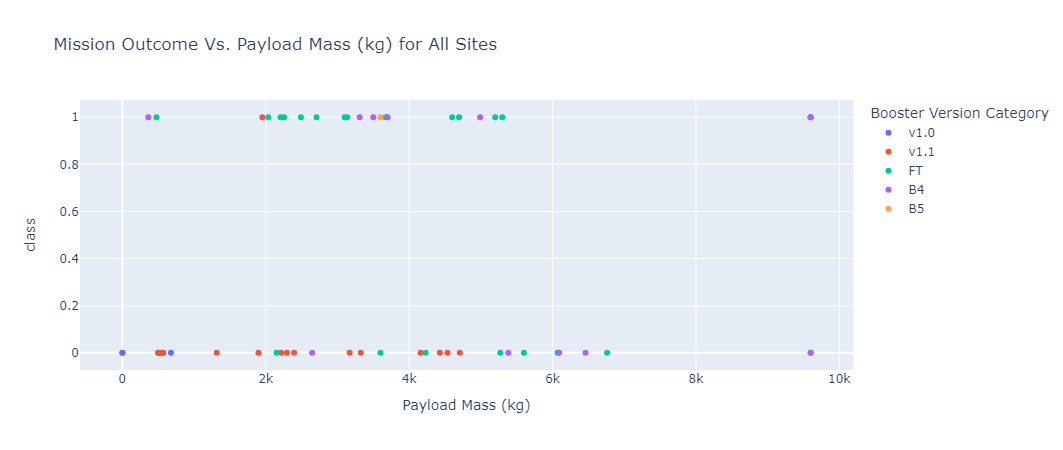

In [7]:
display.Image(b64decode(scat)) 